DOR for test script for name similarity prediction
Import the test data set.Here we have imported the dataset of months August and september 2023.After final processing we get COMBINED_DATA_IND_REFINED having 9531 records.
Generating a test dataset having alerts resolved due to name anchor by finding out the patterns like Match full legal name (resolution is TH), miss-match name (resolution is FH) etc. in V_COMMENTS column. Total alerts we finally get is 3625.
Now go for standardization on all names of customer and watchlist . 
Import the siamese model of several variations - trained but not tuned , model with best set of hyperparameters obtained after tuning using Keras tuner i.e. Random search and Bayesian optimization , model re-trained with these best hyperparameters.
We generate several combinations of name pairs after picking each name from watchlist and forming a pair against customer name. We pick the max score here. If data is absent then we provide a score of 0. (we might change it to -1)
Ultimately we provide one single score for matching of  name and alias name of customer against watchlist.
We observe that none of them performs good on name variations like missing word component, out of order component , truncated compoenent, absent white space and combination of these

In [15]:
import dataiku
import pandas as pd
import numpy as np
import re
import country_converter as coco
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 100
import pickle
import os
import tensorflow
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

Pre-processing for names involves standardization rules as per xls file taken as input for customer name and it's alias name and watch-list and it's alias name.

In [16]:
#df = pd.read_csv("Combined_data_Ind.csv")
my_dataset = dataiku.Dataset("COMBINED_DATA_IND_REFINED")
df = my_dataset.get_dataframe()
df=pd.DataFrame(df.values,columns=df.columns.str.upper())


In [17]:
df.shape

(9462, 112)

#### Filtering the alerts with resolution as TH,THNM and comments as match name

In [18]:
df["V_COMMENTS"]=df["V_COMMENTS"].apply(lambda x: "" if pd.isna(x) else x)
# We assume that all the alerts that are close because of names anchor should have name as text in comments .Now secondly, 
# we need to check that when commenst contain name as string , whether the context of comment is alogned with resolution TH , THNM, FP.
# So we obtain value counts for TH, THNM & FP .Now check with existing observed comments like Match Full leagal name , to see what extent to we approach to these value counts.
patt=re.compile("name",re.IGNORECASE)
print(df[df["V_COMMENTS"].str.contains(patt,re.IGNORECASE)].shape)
print(df[df["V_COMMENTS"].str.contains(patt,re.IGNORECASE)]["V_RESOLUTION"].value_counts())


patt_2=re.compile("Match Full Legal Name|Match Name|Match_ Full Legal Name|Match name|Match_name|Matched Name|Matched name\
Match_Name|Match_Full Legal Name|Match ID and Full Legal Name|Match ID or Full Legal Name|Match ID & Legal Name|Match ID and/or Full Legal Name|Match_ Name|Match Full Legal  Name",re.IGNORECASE)

df_TH_comm_val=pd.DataFrame({})
df_TH_comm_val=df[(df["V_COMMENTS"].str.contains(patt_2)) & (df["V_RESOLUTION"].isin(["TH","THNM"]))]

print(df[(df["V_COMMENTS"].str.contains(patt_2)) & (df["V_RESOLUTION"].isin(["TH","THNM"]))].shape)

(3844, 112)
FP      3175
TH       636
THNM      33
Name: V_RESOLUTION, dtype: int64
(659, 112)


We see that out of 69,035 alerts with comments as name & resolution TH, THNM we are able to validate for 64061.Refer jupyter noreboook Comment_Analysis_For_Names to see the alerts where comments cannot be validated.

#### Filtering the alerts with resolution as FP and comments as name miss-match


In [19]:
df[(df["V_COMMENTS"].str.contains(patt)) & (df["V_RESOLUTION"]=="FP")].shape

(3175, 112)

In [20]:
# We need to check whether the context in which name is coming in comments is aligned with resolution FP.So we have existing 
# comments based on which we validate that upto how much alerts with name in comments & FP can we achieve.
patt_3=re.compile("Mismatch Full Legal Name|not sounds similar|not sound similar",re.IGNORECASE)
print(df[(df["V_COMMENTS"].str.contains(patt_3)) & (df["V_RESOLUTION"]=="FP")]["V_COMMENTS"].shape)
# Refer Comment_Analysis_For_Names to see the alerts where commenst could not be validated i.e 14 thousand alerts approx.

df_FP_comm_val=df[(df["V_COMMENTS"].str.contains(patt_3)) & (df["V_RESOLUTION"]=="FP")]

(2966,)


In [21]:
print(df_TH_comm_val.shape[0]+df_FP_comm_val.shape[0])
df_comm_val=pd.concat([df_TH_comm_val,df_FP_comm_val],axis=0,join="outer")
df_comm_val = df_comm_val.sample(frac=1, random_state=42).reset_index(drop=True)
df_comm_val.head()

3625


,N_PARTY_WATCHLIST_MATCH_ID,V_UCIF_ID,V_SCREENING_ID,N_WATCHLIST_PROFILE_ID,N_MATCH_SCORE,V_WATCHLIST_PARTY_NAME,V_INFO_SOURCE,V_WL_STATUS_CODE,D_DT_OF_SCREENING,V_COMMENTS,N_WORKFLOW_ID,F_RECENT_MATCH,V_RESOLUTION,V_REASON,F_DELTA_MATCH,D_CREATED_DTM,V_CREATED_BY,D_UPDATED_DTM,V_UPDATED_BY,N_SCREENING_VERSION,V_COUNTRY_OF_ONBOARDING,V_UCIF_ID_1,V_PARTY_CLASS,V_PARTY_TYPE,V_REGD_PARTY_NAME,V_ALIAS_NAME,V_GENDER,V_PARTY_FIRST_NAME,V_PARTY_MID_NAME,V_PARTY_LST_NAME,D_INCORPORATION_DATE,V_COUNTRY_OF_INCORP,V_COUNTRY_OF_BIRTH,V_PREVIOUS_NAME_IMMEDIATE,V_PREVIOUS_NAME_1,V_PREVIOUS_NAME_2,D_DOB,D_DECEASED_DATE,F_DECEASED_FLAG,V_COUNTRY_OF_BIRTH_1,V_FATHERS_NAME,V_MOTHERS_NAME,V_CREATED_BY_1,D_CREATED_DTM_1,V_UPDATED_BY_1,D_UPDATED_DTM_1,F_DELETE_FLAG,F_UPDATE_FLAG,V_LEGAL_STRUCTURE,F_PEP_STATUS,F_FMLY_PEP_STATUS,V_PEP_BIOGRAPHY,V_PEP_RELATIONSHIP,V_PEP_NAME,V_UCIF_ID_1_1,V_COUNTRY_OF_ONBOARDING_1,V_PARTY_GROUP,V_CITIZENSHIP,V_DUAL_CITIZENSHIP,V_OCC_CODE,V_COUNTRY_PERM_RES,V_SCREENING_STATUS,V_SCREENING_ID_1,V_CREATED_BY_PL,D_CREATED_DTM_PL,V_UPDATED_BY_PL,D_UPDATED_DTM_1_1,F_DELETE_FLAG_1,F_UPDATE_FLAG_1,N_SCREENING_VERSION_1,V_EMPLOYER_NAME,D_LAST_SCREENING_DATE,V_RACE,V_PARTY_CLASS_LEGACY,V_TITLE,V_RESIDENT_STATUS,V_UCIF_ID_2,AGG_UNQ_DOC_ID,AGG_V_ID_TYPE,V_PRIM_PTY_UCIF_ID,AGG_SEC_PTY_UCIF_ID,V_RELATION_TYPE_CD,N_NUMBER_OF_SHARES,N_SHAREHOLDING_PERCENT,V_REGD_PARTY_NAME_1,N_WATCHLIST_PROFILE_ID_1,V_WATCHLIST_PROFILE_UID,V_PROFILE_TYPE,V_PROFILE_NAME,V_ALIASES,V_TITLE_1,V_DOB,V_DOI,V_NATIONALITY,V_COI,V_IDENTIFICATION_NO,V_IC_NO,V_PLACE_OF_BIRTH,V_GENDER_1,V_PEP_POSITION,V_BIOGRAPHY,V_INFO_SOURCE_1,V_REMARK,V_WL_STATUS_CODE_1,V_STATUS,D_CREATED_DTM_2,D_UPDATED_DTM_2,V_CATEGORY,V_SUB_CATEGORY,V_LOCATION_DETAILS,V_AGE,V_AGE_AS_OF_DATE
0,7785493,24896719,6518691,15485514,100.0,AIEN SHAZIELLA BINTI KAMAROLZAMAN,MLEX,82,2023-09-05 00:00:00,"Match Name, Gender, DOB, Nationality & ID Number_NRIC",NaN,N,TH,PSI,Y,2023-09-04 16:00:00+00:00,89ca0d85-698c-409c-93f3-11ff27a27969,2023-09-11 16:29:12.123527,24405,1.0,MYS,24896719,I,12000.0,AIEN SHAZIELLA BINTI KAMAROLZAMAN,NaN,F,NaN,NaN,NaN,NaN,NaN,DD,NaN,NaN,NaN,1993-02-16 00:00:00,NaN,N,DD,NaN,NaN,M01421H,2013-10-17 05:53:46+00:00,NaN,1900-01-01 00:00:00,N,NaN,INDV,NaN,NaN,NaN,NaN,NaN,24896719,MYS,BUM,MYS,NaN,U002,MYS,HITS,6518691,M01421H,2013-10-17 05:53:46+00:00,00024405,2023-09-11 16:29:12.132198,N,NaN,1,NaN,2020-09-08 02:52:00,MYS,500.0,MSS,CTZN,24896719.0,"[""930216016054""]","[""NWIC""]",NaN,NaN,NaN,NaN,NaN,NaN,15485514,FM33331,I,AIEN SHAZIELLA BINTI KAMAROLZAMAN,NaN,NaN,16/02/1993,NaN,MALAYSIA,NaN,NaN,930216016054.0,NaN,F,NaN,EXIT DUE TO ML CONCERN,MLEX,EXIT DUE TO ML CONCERN,82,A,2023-09-05 12:45:00.551000+00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,7713232,124753336,4270290,15413720,90.0,Jian ZHANG,ANEWS,76,2023-08-18 00:00:00,Mismatch Full Legal Name_Name does not sound similar.,NaN,N,FP,PI,N,2023-08-17 16:00:00+00:00,0dba7948-02f4-46c6-a3f7-974647d22af3,2023-08-31 20:22:28.840936,21222,1.0,MYS,124753336,I,11000.0,ZHANG QIAN,NaN,F,ZHANG,NaN,QIAN,NaN,NaN,CHN,NaN,NaN,NaN,1980-03-24 00:00:00,NaN,N,CHN,NaN,NaN,M121067,2010-11-08 02:22:32+00:00,00024055,2023-01-16 15:59:03.28,N,NaN,INDV,N,N,NaN,NaN,NaN,124753336,MYS,EXT,CHN,NaN,U001,MYS,NOHITS,4270290,M121067,2010-11-08 02:22:32+00:00,00021222,2023-08-31 20:22:28.860184,N,NaN,1,NaN,2022-02-11 00:00:00,OTH,501.0,MRS,MM2H,124753336.0,"[""G55407075""]","[""PASS""]",NaN,NaN,NaN,NaN,NaN,NaN,15413720,4409004,I,Jian ZHANG,NaN,NaN,NaN,NaN,CHINA,NaN,NaN,NaN,NaN,U,NaN,[BIOGRAPHY] General Manager of Ping An Life Insurance Company of China Yanan Central Sub Branch ...,ANEWS,ADVERSE MEDIA,76,A,2023-08-18 12:44:59.893000+00:00,NaN,INDIVIDUAL,NaN,"~ Yanan, Shaanxi ~ CHINA",NaN,NaN
2,7723412,75169411,6173366,15427961,90.0,Xiaolei LI,PEPEX,81,2023-08-22 00:00:00,Mismatch Full Legal Name,NaN,N,FP,PI,N,2023-08-21 16:00:00+00:00,92e35387-235a-47dd-b090-dc4dacf69b23,2023-09-26 17:38:08.031342,77754,1.0,MYS,75169411,I,11000.0,LI XIAOWEI,NaN,M,LI,NaN,XIAOWEI,NaN,NaN,CHN,NaN

In [22]:
df_comm_val

,N_PARTY_WATCHLIST_MATCH_ID,V_UCIF_ID,V_SCREENING_ID,N_WATCHLIST_PROFILE_ID,N_MATCH_SCORE,V_WATCHLIST_PARTY_NAME,V_INFO_SOURCE,V_WL_STATUS_CODE,D_DT_OF_SCREENING,V_COMMENTS,N_WORKFLOW_ID,F_RECENT_MATCH,V_RESOLUTION,V_REASON,F_DELTA_MATCH,D_CREATED_DTM,V_CREATED_BY,D_UPDATED_DTM,V_UPDATED_BY,N_SCREENING_VERSION,V_COUNTRY_OF_ONBOARDING,V_UCIF_ID_1,V_PARTY_CLASS,V_PARTY_TYPE,V_REGD_PARTY_NAME,V_ALIAS_NAME,V_GENDER,V_PARTY_FIRST_NAME,V_PARTY_MID_NAME,V_PARTY_LST_NAME,D_INCORPORATION_DATE,V_COUNTRY_OF_INCORP,V_COUNTRY_OF_BIRTH,V_PREVIOUS_NAME_IMMEDIATE,V_PREVIOUS_NAME_1,V_PREVIOUS_NAME_2,D_DOB,D_DECEASED_DATE,F_DECEASED_FLAG,V_COUNTRY_OF_BIRTH_1,V_FATHERS_NAME,V_MOTHERS_NAME,V_CREATED_BY_1,D_CREATED_DTM_1,V_UPDATED_BY_1,D_UPDATED_DTM_1,F_DELETE_FLAG,F_UPDATE_FLAG,V_LEGAL_STRUCTURE,F_PEP_STATUS,F_FMLY_PEP_STATUS,V_PEP_BIOGRAPHY,V_PEP_RELATIONSHIP,V_PEP_NAME,V_UCIF_ID_1_1,V_COUNTRY_OF_ONBOARDING_1,V_PARTY_GROUP,V_CITIZENSHIP,V_DUAL_CITIZENSHIP,V_OCC_CODE,V_COUNTRY_PERM_RES,V_SCREENING_STATUS,V_SCREENING_ID_1,V_CREATED_BY_PL,D_CREATED_DTM_PL,V_UPDATED_BY_PL,D_UPDATED_DTM_1_1,F_DELETE_FLAG_1,F_UPDATE_FLAG_1,N_SCREENING_VERSION_1,V_EMPLOYER_NAME,D_LAST_SCREENING_DATE,V_RACE,V_PARTY_CLASS_LEGACY,V_TITLE,V_RESIDENT_STATUS,V_UCIF_ID_2,AGG_UNQ_DOC_ID,AGG_V_ID_TYPE,V_PRIM_PTY_UCIF_ID,AGG_SEC_PTY_UCIF_ID,V_RELATION_TYPE_CD,N_NUMBER_OF_SHARES,N_SHAREHOLDING_PERCENT,V_REGD_PARTY_NAME_1,N_WATCHLIST_PROFILE_ID_1,V_WATCHLIST_PROFILE_UID,V_PROFILE_TYPE,V_PROFILE_NAME,V_ALIASES,V_TITLE_1,V_DOB,V_DOI,V_NATIONALITY,V_COI,V_IDENTIFICATION_NO,V_IC_NO,V_PLACE_OF_BIRTH,V_GENDER_1,V_PEP_POSITION,V_BIOGRAPHY,V_INFO_SOURCE_1,V_REMARK,V_WL_STATUS_CODE_1,V_STATUS,D_CREATED_DTM_2,D_UPDATED_DTM_2,V_CATEGORY,V_SUB_CATEGORY,V_LOCATION_DETAILS,V_AGE,V_AGE_AS_OF_DATE
0,7785493,24896719,6518691,15485514,100.0,AIEN SHAZIELLA BINTI KAMAROLZAMAN,MLEX,82,2023-09-05 00:00:00,"Match Name, Gender, DOB, Nationality & ID Number_NRIC",NaN,N,TH,PSI,Y,2023-09-04 16:00:00+00:00,89ca0d85-698c-409c-93f3-11ff27a27969,2023-09-11 16:29:12.123527,24405,1.0,MYS,24896719,I,12000.0,AIEN SHAZIELLA BINTI KAMAROLZAMAN,NaN,F,NaN,NaN,NaN,NaN,NaN,DD,NaN,NaN,NaN,1993-02-16 00:00:00,NaN,N,DD,NaN,NaN,M01421H,2013-10-17 05:53:46+00:00,NaN,1900-01-01 00:00:00,N,NaN,INDV,NaN,NaN,NaN,NaN,NaN,24896719,MYS,BUM,MYS,NaN,U002,MYS,HITS,6518691,M01421H,2013-10-17 05:53:46+00:00,00024405,2023-09-11 16:29:12.132198,N,NaN,1,NaN,2020-09-08 02:52:00,MYS,500.0,MSS,CTZN,24896719.0,"[""930216016054""]","[""NWIC""]",NaN,NaN,NaN,NaN,NaN,NaN,15485514,FM33331,I,AIEN SHAZIELLA BINTI KAMAROLZAMAN,NaN,NaN,16/02/1993,NaN,MALAYSIA,NaN,NaN,930216016054.0,NaN,F,NaN,EXIT DUE TO ML CONCERN,MLEX,EXIT DUE TO ML CONCERN,82,A,2023-09-05 12:45:00.551000+00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,7713232,124753336,4270290,15413720,90.0,Jian ZHANG,ANEWS,76,2023-08-18 00:00:00,Mismatch Full Legal Name_Name does not sound similar.,NaN,N,FP,PI,N,2023-08-17 16:00:00+00:00,0dba7948-02f4-46c6-a3f7-974647d22af3,2023-08-31 20:22:28.840936,21222,1.0,MYS,124753336,I,11000.0,ZHANG QIAN,NaN,F,ZHANG,NaN,QIAN,NaN,NaN,CHN,NaN,NaN,NaN,1980-03-24 00:00:00,NaN,N,CHN,NaN,NaN,M121067,2010-11-08 02:22:32+00:00,00024055,2023-01-16 15:59:03.28,N,NaN,INDV,N,N,NaN,NaN,NaN,124753336,MYS,EXT,CHN,NaN,U001,MYS,NOHITS,4270290,M121067,2010-11-08 02:22:32+00:00,00021222,2023-08-31 20:22:28.860184,N,NaN,1,NaN,2022-02-11 00:00:00,OTH,501.0,MRS,MM2H,124753336.0,"[""G55407075""]","[""PASS""]",NaN,NaN,NaN,NaN,NaN,NaN,15413720,4409004,I,Jian ZHANG,NaN,NaN,NaN,NaN,CHINA,NaN,NaN,NaN,NaN,U,NaN,[BIOGRAPHY] General Manager of Ping An Life Insurance Company of China Yanan Central Sub Branch ...,ANEWS,ADVERSE MEDIA,76,A,2023-08-18 12:44:59.893000+00:00,NaN,INDIVIDUAL,NaN,"~ Yanan, Shaanxi ~ CHINA",NaN,NaN
2,7723412,75169411,6173366,15427961,90.0,Xiaolei LI,PEPEX,81,2023-08-22 00:00:00,Mismatch Full Legal Name,NaN,N,FP,PI,N,2023-08-21 16:00:00+00:00,92e35387-235a-47dd-b090-dc4dacf69b23,2023-09-26 17:38:08.031342,77754,1.0,MYS,75169411,I,11000.0,LI XIAOWEI,NaN,M,LI,NaN,XIAOWEI,NaN,NaN,CHN,NaN

In [23]:
from Name_pre_process import process_name
df_comm_val=process_name(df_comm_val)


46     MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD 
47    ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB 
48                            NOOR |NOR |NUUR |NUR 
49                             AHMAD |AHMED |AHMET 
50                              ABDULLAH |ABDOLLAH 
51                    YUSOFF |YUSOF |YUSUFF |YUSUF 
Name: V_SCREENING_VALUE_1, dtype: object
HAJI |HAJJAH |HAJAH |HJH |HJ |ALHAJ |HADJI 
WIRA |PANGLIMA |IR |DR. |PROF. |SR 
K.D.Y.T.M. |K.D.Y.M.M. |D.Y.M.M. |D.Y.T.M. |Y.T.M. |D.Y.A.M. |Y.M.M. |Y.A.M. |Y.BHG. |KDYTM |KDYMM |DYMM |DYTM |DYAM |YMM |YTM 
YANG  DI PERTUAN  AGONG |DULI  YANG  MAHA  MULIA  SERI  PADUKA  BAGINDA 
TIMBALAN  YANG  DI PERTUAN  AGONG 
YANG DI PERTUAN BESAR |YANG  DI PERTUA  NEGERI  |SULTAN 
RAJA  PERMAISURI  AGONG 
TUNKU  AMPUAN  BESAR |TUNKU  AMPUAN |TUNKU  PUAN  BESAR |SULTANAH |TENGKU  AMPUAN  BESAR |TENGKU  AMPUAN  MAHKOTA |TENGKU  AMPUAN | TENGKU  BESAR |TENGKU  MAHKOTA |PADUKA  BONDA  RAJA 
RAJA  PERMAISURI |PERMAISURI |RAJA  MUDA |RAJA  PUAN  MUDA |RAJA

In [24]:
df_comm_val.columns

Index(['ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES', 'V_COMMENTS', 'V_RESOLUTION', 'N_MATCH_SCORE', 'N_PARTY_WATCHLIST_MATCH_ID', 'V_UCIF_ID', 'N_WATCHLIST_PROFILE_ID'], dtype='object')

In [25]:
df_comm_val["WL_NAMES"]=df_comm_val["ALL_WL_NAMES"].apply(lambda x: x[6])
df_comm_val["PARTY_NAMES"]=df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: x[0])

# Need to drop the alerts where any of the name is empty string.
print(df_comm_val[ (df_comm_val["PARTY_NAMES"].isin([""])) | (df_comm_val["WL_NAMES"].isin([""]))][["PARTY_NAMES","WL_NAMES"]].shape)
df_comm_val.drop(df_comm_val[ (df_comm_val["PARTY_NAMES"].isin([""])) | (df_comm_val["WL_NAMES"].isin([""]))].index,axis=0,inplace=True)

# none of them training data has customer or watchlist data empty
df_comm_val[ (df_comm_val["PARTY_NAMES"].isin([""])) | (df_comm_val["WL_NAMES"].isin([""]))][["PARTY_NAMES","WL_NAMES"]]

(240, 2)


,PARTY_NAMES,WL_NAMES


In [26]:
df_comm_val.head()

,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,V_COMMENTS,V_RESOLUTION,N_MATCH_SCORE,N_PARTY_WATCHLIST_MATCH_ID,V_UCIF_ID,N_WATCHLIST_PROFILE_ID,WL_NAMES,PARTY_NAMES
0,"[, , , , , , , , , , , , , , , ]","[AIEN SHAZIELLA KAMAROLZAMAN, , , ]","[, , , , , , AIEN SHAZIELLA KAMAROLZAMAN]","Match Name, Gender, DOB, Nationality & ID Number_NRIC",TH,100.0,7785493,24896719,15485514,AIEN SHAZIELLA KAMAROLZAMAN,AIEN SHAZIELLA KAMAROLZAMAN
1,"[, , , , , , , , , , , , , , , ]","[ZHANG QIAN, , , ]","[, , , , , , JIAN ZHANG]",Mismatch Full Legal Name_Name does not sound similar.,FP,90.0,7713232,124753336,15413720,JIAN ZHANG,ZHANG QIAN
2,"[, , , , , , , , , , , , , , , ]","[LI XIAOWEI, , , ]","[LIAXIAO LEI, , , , , , XIAOLEI LI]",Mismatch Full Legal Name,FP,90.0,7723412,75169411,15427961,XIAOLEI LI,LI XIAOWEI
3,"[, , , , , , , , , , , , , , , ]","[MOHD ASRI BIN ABDUL RAHMAN, , , ]","[, , , , , , MOHD SABRI ABDUL RAHMAN]",Mismatch Full Legal Name_Name does not sound similar,FP,92.0,7679524,53562715,15389813,MOHD SABRI ABDUL RAHMAN,MOHD ASRI BIN ABDUL RAHMAN
4,"[, , , , , , , , , , , , , , , ]","[LI YUNYING, , , ]","[LIAYU YING, , , , , , YUYING LI]",Mismatch Full Legal Name_Native Name (Chinese Character Difference) - Comparison was made betwee...,FP,90.0,7789080,55525626,15482522,YUYING LI,LI YUNYING


# standardization rules

In [9]:

my_dataset = dataiku.Dataset("Standradization_rules_draft__base_line_model")
scr_rules = my_dataset.get_dataframe()
print(scr_rules.loc[46:51,"V_SCREENING_VALUE_1"])
scr_rules.loc[46:51,"V_SCREENING_VALUE_1"]=scr_rules.loc[46:51,"V_SCREENING_VALUE_1"].apply(lambda x: x.lstrip("( ").rstrip(")"))

scr_rules_2=scr_rules.iloc[21:45,:] # Punctuation marks
scr_rules_3=scr_rules.iloc[46:52,:]  #  Standardization rules
scr_rules=scr_rules.iloc[0:16,:]    # patronym & honourary titles



46     MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD 
47    ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB 
48                            NOOR |NOR |NUUR |NUR 
49                             AHMAD |AHMED |AHMET 
50                              ABDULLAH |ABDOLLAH 
51                    YUSOFF |YUSOF |YUSUFF |YUSUF 
Name: V_SCREENING_VALUE_1, dtype: object


In [10]:
df["V_COMMENTS"]=df["V_COMMENTS"].apply(lambda x: '' if pd.isna(x) else x)

# Customer Name 

In [11]:
df_comm_val['V_PREVIOUS_NAME_1']=df_comm_val['V_PREVIOUS_NAME_1'].apply(lambda x : [""]  if pd.isna(x) else [str(x).upper()])
df_comm_val['V_PREVIOUS_NAME_2']=df_comm_val['V_PREVIOUS_NAME_2'].apply(lambda x :  [""] if pd.isna(x) else [str(x).upper()])
df_comm_val['V_PREVIOUS_NAME_IMMEDIATE']=df_comm_val['V_PREVIOUS_NAME_IMMEDIATE'].apply(lambda x :  [""] if pd.isna(x) else [str(x).upper()])


In [12]:
# pre-processing on "V_REGD_PARTY_NAME"

df_comm_val["V_REGD_PARTY_NAME"]=df_comm_val["V_REGD_PARTY_NAME"].apply(lambda x : [""]  if pd.isna(x) else [str(x).upper()])
# not more than element is present in V_REGD_PARTY_NAMES
df_comm_val[df_comm_val["V_REGD_PARTY_NAME"].apply(lambda x: len(x)>1)]

,N_PARTY_WATCHLIST_MATCH_ID,V_UCIF_ID,V_SCREENING_ID,N_WATCHLIST_PROFILE_ID,N_MATCH_SCORE,V_WATCHLIST_PARTY_NAME,V_INFO_SOURCE,V_WL_STATUS_CODE,D_DT_OF_SCREENING,V_COMMENTS,N_WORKFLOW_ID,F_RECENT_MATCH,V_RESOLUTION,V_REASON,F_DELTA_MATCH,D_CREATED_DTM,V_CREATED_BY,D_UPDATED_DTM,V_UPDATED_BY,N_SCREENING_VERSION,V_COUNTRY_OF_ONBOARDING,V_UCIF_ID_1,V_PARTY_CLASS,V_PARTY_TYPE,V_REGD_PARTY_NAME,V_ALIAS_NAME,V_GENDER,V_PARTY_FIRST_NAME,V_PARTY_MID_NAME,V_PARTY_LST_NAME,D_INCORPORATION_DATE,V_COUNTRY_OF_INCORP,V_COUNTRY_OF_BIRTH,V_PREVIOUS_NAME_IMMEDIATE,V_PREVIOUS_NAME_1,V_PREVIOUS_NAME_2,D_DOB,D_DECEASED_DATE,F_DECEASED_FLAG,V_COUNTRY_OF_BIRTH_1,V_FATHERS_NAME,V_MOTHERS_NAME,V_CREATED_BY_1,D_CREATED_DTM_1,V_UPDATED_BY_1,D_UPDATED_DTM_1,F_DELETE_FLAG,F_UPDATE_FLAG,V_LEGAL_STRUCTURE,F_PEP_STATUS,F_FMLY_PEP_STATUS,V_PEP_BIOGRAPHY,V_PEP_RELATIONSHIP,V_PEP_NAME,V_UCIF_ID_1_1,V_COUNTRY_OF_ONBOARDING_1,V_PARTY_GROUP,V_CITIZENSHIP,V_DUAL_CITIZENSHIP,V_OCC_CODE,V_COUNTRY_PERM_RES,V_SCREENING_STATUS,V_SCREENING_ID_1,V_CREATED_BY_PL,D_CREATED_DTM_PL,V_UPDATED_BY_PL,D_UPDATED_DTM_1_1,F_DELETE_FLAG_1,F_UPDATE_FLAG_1,N_SCREENING_VERSION_1,V_EMPLOYER_NAME,D_LAST_SCREENING_DATE,V_RACE,V_PARTY_CLASS_LEGACY,V_TITLE,V_RESIDENT_STATUS,V_UCIF_ID_2,AGG_UNQ_DOC_ID,AGG_V_ID_TYPE,V_PRIM_PTY_UCIF_ID,AGG_SEC_PTY_UCIF_ID,V_RELATION_TYPE_CD,N_NUMBER_OF_SHARES,N_SHAREHOLDING_PERCENT,V_REGD_PARTY_NAME_1,N_WATCHLIST_PROFILE_ID_1,V_WATCHLIST_PROFILE_UID,V_PROFILE_TYPE,V_PROFILE_NAME,V_ALIASES,V_TITLE_1,V_DOB,V_DOI,V_NATIONALITY,V_COI,V_IDENTIFICATION_NO,V_IC_NO,V_PLACE_OF_BIRTH,V_GENDER_1,V_PEP_POSITION,V_BIOGRAPHY,V_INFO_SOURCE_1,V_REMARK,V_WL_STATUS_CODE_1,V_STATUS,D_CREATED_DTM_2,D_UPDATED_DTM_2,V_CATEGORY,V_SUB_CATEGORY,V_LOCATION_DETAILS,V_AGE,V_AGE_AS_OF_DATE


In [13]:
# imputation done
df_comm_val[["V_REGD_PARTY_NAME", 'V_PREVIOUS_NAME_IMMEDIATE', 'V_PREVIOUS_NAME_1','V_PREVIOUS_NAME_2']]
name_df_comm_val=pd.DataFrame({})
name_df_comm_val["ALL_PARTY_NAMES"]=df_comm_val[["V_REGD_PARTY_NAME", 'V_PREVIOUS_NAME_IMMEDIATE', 'V_PREVIOUS_NAME_1','V_PREVIOUS_NAME_2']].apply(lambda x: x[0]+x[1]+x[2]+x[3],axis=1)

In [14]:
# Patronym , ' - , Honourary Titles 
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(k," ",x[0]),re.sub(k," ",x[1]),re.sub(k," ",x[2]),re.sub(k," ",x[3])])

#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\'","",x[0]),re.sub("\'","",x[1]),re.sub("\'","",x[2]),re.sub("\'","",x[3])])

# - dash
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("-"," ",x[0]),re.sub("-"," ",x[1]),re.sub("-"," ",x[2]),re.sub("-"," ",x[3])])


for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():
    print(k)
    name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("^("+k+")","",x[0]),re.sub("^("+k+")","",x[1]),re.sub("^("+k+")","",x[2]),re.sub("^("+k+")","",x[3])]) 
# We need to remove HAJI & all such terms if in case they come in b/w names.
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",i) for i in x])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",i) for i in x])


        # Need to add a cap ^ to remove only the names where titles come as prefix.

HAJI |HAJJAH |HAJAH |HJH |HJ |ALHAJ |HADJI 
WIRA |PANGLIMA |IR |DR. |PROF. |SR 
K.D.Y.T.M. |K.D.Y.M.M. |D.Y.M.M. |D.Y.T.M. |Y.T.M. |D.Y.A.M. |Y.M.M. |Y.A.M. |Y.BHG. |KDYTM |KDYMM |DYMM |DYTM |DYAM |YMM |YTM 
YANG  DI PERTUAN  AGONG |DULI  YANG  MAHA  MULIA  SERI  PADUKA  BAGINDA 
TIMBALAN  YANG  DI PERTUAN  AGONG 
YANG DI PERTUAN BESAR |YANG  DI PERTUA  NEGERI  |SULTAN 
RAJA  PERMAISURI  AGONG 
TUNKU  AMPUAN  BESAR |TUNKU  AMPUAN |TUNKU  PUAN  BESAR |SULTANAH |TENGKU  AMPUAN  BESAR |TENGKU  AMPUAN  MAHKOTA |TENGKU  AMPUAN | TENGKU  BESAR |TENGKU  MAHKOTA |PADUKA  BONDA  RAJA 
RAJA  PERMAISURI |PERMAISURI |RAJA  MUDA |RAJA  PUAN  MUDA |RAJA  PUAN  BESAR |RAJA  DI HILIR |TENGKU  PUAN  MUDA |TENGKU  PUAN |YANG  DI-PERTUAN  MUDA |YANG  DI-PERTUAN  BESAR 
TUANKU |TUNKU |TUN 
RAJA |TENGKU |MEK |NIK |TUAN |WAN |PUTERI |PUTRI |AWANG |ABANG |DAYANG |CIK  PUAN  BESAR |CIK  PUAN |ENCHE  BESAR |CHE  PUAN  BESAR |SYED |SY |SAYED |SHARIFAH |SH |SYARIFAH 
TAN  SRI |DATUK  SERI |DATUK  SRI |DATUK |DAT

In [15]:
# Pre-processing (Step-2) & getting Alias names
# () Alias name  -  below alias name 2 column, has list in each row.
name_df_comm_val["V_ALIAS_NAME_2"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.findall("\(.+\)",x[i]) for i in range(len(x))])
                                                                

name_df_comm_val["V_ALIAS_NAME_2"]=name_df_comm_val["V_ALIAS_NAME_2"].apply(lambda x: [x[i][0].lstrip("(").rstrip(")") if len(x[i])>0 else "" for i in range(len(x))])
 
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(" \(.+\)","",x[i]) for i in range(len(x))])


#@ 
name_df_comm_val["V_ALIAS_NAME_3"]=[""]*(df_comm_val.shape[0])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.split("@",x[i]) for i in range(len(x))])

name_df_comm_val["V_ALIAS_NAME_3"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [x[i][1].lstrip(" ") if len(x[i]) >1 else "" for i in range(len(x))])

name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply( lambda x: [x[i][0].rstrip(" ") for i in range(len(x)) ])
                                                                    


# slash - if more than one slash than issue shall arise
name_df_comm_val["V_ALIAS_NAME_4"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.split(" / ",x[i]) for i in range(len(x))])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["V_ALIAS_NAME_4"].apply(lambda x:[x[i][0] for i in range(len(x))])
name_df_comm_val["V_ALIAS_NAME_4"]=name_df_comm_val["V_ALIAS_NAME_4"].apply(lambda x:[x[i][1] if len(x[i])>1 else "" for i in range(len(x))])


invalid escape sequence \(
invalid escape sequence \(
invalid escape sequence \(
invalid escape sequence \(


In [16]:
# Accented Characters
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Á,Ä,Â,Ã]","A",x[0]),re.sub("[Á,Ä,Â,Ã]","A",x[1]),re.sub("[Á,Ä,Â,Ã]","A",x[2]),re.sub("[Á,Ä,Â,Ã]","A",x[3])])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Å]","AA",x[0]),re.sub("[Å]","AA",x[1]),re.sub("[Å]","AA",x[2]),re.sub("[Å]","AA",x[3])])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[É,Ë,Ê,È]","E",x[0]),re.sub("[É,Ë,Ê,È]","E",x[1]),re.sub("[É,Ë,Ê,È]","E",x[2]),re.sub("[É,Ë,Ê,È]","E",x[3])])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Í,Ï,Î]","I",x[0]),re.sub("[Í,Ï,Î]","I",x[1]),re.sub("[Í,Ï,Î]","I",x[2]),re.sub("[Í,Ï,Î]","I",x[3])])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ó,Ô,Ö,Õ]","O",x[0]),re.sub("[Ó,Ô,Ö,Õ]","O",x[1]),re.sub("[Ó,Ô,Ö,Õ]","O",x[2]),re.sub("[Ó,Ô,Ö,Õ]","O",x[3])])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ú,Ü,Ù]","U",x[0]),re.sub("[Ú,Ü,Ù]","U",x[1]),re.sub("[Ú,Ü,Ù]","U",x[2]),re.sub("[Ú,Ü,Ù]","U",x[3])])

name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ø]","OE",x[0]),re.sub("[Ø]","OE",x[1]),re.sub("[Ø]","OE",x[2]),re.sub("[Ø]","OE",x[3])])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ç]","C",x[0]),re.sub("[Ç]","C",x[1]),re.sub("[Ç]","C",x[2]),re.sub("[Ç]","C",x[3])])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ñ]","N",x[0]),re.sub("[Ñ]","N",x[1]),re.sub("[Ñ]","N",x[2]),re.sub("[Ñ]","N",x[3])])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ý]","Y",x[0]),re.sub("[Ý]","Y",x[1]),re.sub("[Ý]","Y",x[2]),re.sub("[Ý]","Y",x[3])])
                                                                                              
    
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ]) 


In [17]:
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ])
df_comm_val["V_REGD_PARTY_NAME"]=df_comm_val["V_REGD_PARTY_NAME"].apply(lambda x: x[0])

### Punctuation Marks

In [18]:
print(df_comm_val[df_comm_val["V_REGD_PARTY_NAME"].str.contains(", ")]["V_REGD_PARTY_NAME"])
df_comm_val[df_comm_val["V_REGD_PARTY_NAME"].str.contains(",\s")]["V_REGD_PARTY_NAME"]
df_comm_val[df_comm_val["V_REGD_PARTY_NAME"].str.contains("\s+,\s+")]["V_REGD_PARTY_NAME"]

28           ZHANG, JIE
29         LI, HONGLING
40        HOU, ZHANGPAN
51            WANG, JIN
54            CHEN, LEI
82           WANG, JING
91          ZHANG, YONG
114         ZHANG, JING
206            LI, YANG
222      WANG, XIAODONG
271         ZHANG, TING
274         XIONG, TING
276            LI, YANG
281           YANG, FAN
284            LI, YANG
288            LI, YANG
297         LIU, JIAWEN
317            LI, YANG
376          LIANG, HAO
383         ZHANG, JING
450           ZHANG, BO
457            LI, YANG
458         ZHANG, QING
489         ZHANG, HONG
510          YANG, YANG
525         FENG, QIANG
548         ZHANG, YING
552         LIU, JUNJIE
625          WANG, QING
632         LI, YUNFENG
651          WANG, QING
703         ZHANG, TING
709         ZHANG, QING
759         ZHANG, TING
760         ZHANG, YING
764            LI, YANG
807         CHENG, XIAO
817            LI, YANG
853         ZHANG, TING
859         WANG, HAIBO
864         YANG, GUANG
883         ZHAN

invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s


2791    CHEN , LIRONG
Name: V_REGD_PARTY_NAME, dtype: object

In [19]:
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\s+,\s+"," ",i) for i in x])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\s+,"," ",i) for i in x])
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(",\s+"," ",i) for i in x])

invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s


In [20]:
scr_rules_2
for j in scr_rules_2["V_SCREENING_VALUE_1"]:
    print(j)
    name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(j," ",x[i]) for i in range(len(x))])

~
!
#
\$
%
\^
&
\*
_
-
\+
=
\{
\}
\[
\]
\|
\\\\
:
;
\"
<
>
\?


### Standardized Names

In [21]:
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:
    print(k[0],k[1])
    name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])

MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD   MOHD 
ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB   ABDUL 
NOOR |NOR |NUUR |NUR   NOOR 
AHMAD |AHMED |AHMET   AHMAD 
ABDULLAH |ABDOLLAH   ABDULLAH 
YUSOFF |YUSOF |YUSUFF |YUSUF   YUSOFF 


In [22]:
# For any other miscellaneous character
name_df_comm_val["ALL_PARTY_NAMES"]=name_df_comm_val["ALL_PARTY_NAMES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x))])

invalid escape sequence \s
invalid escape sequence \s


In [23]:
# V_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
name_df_comm_val["GROUP_ALIAS_NAME_1"]=name_df_comm_val[["V_ALIAS_NAME_2","V_ALIAS_NAME_3","V_ALIAS_NAME_4"]].apply(lambda x: x[0]+x[1]+x[2],axis=1)
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:
    print(i)
    #name_df_comm_val["V_ALIAS_NAME_2"]=name_df_comm_val["V_ALIAS_NAME_2"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])
    name_df_comm_val["GROUP_ALIAS_NAME_1"]=name_df_comm_val["GROUP_ALIAS_NAME_1"].apply(lambda x: [re.sub(str(i)," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:
    print(k[0],k[1])
    name_df_comm_val["GROUP_ALIAS_NAME_1"]=name_df_comm_val["GROUP_ALIAS_NAME_1"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
name_df_comm_val["GROUP_ALIAS_NAME_1"]=name_df_comm_val["GROUP_ALIAS_NAME_1"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ])                                                                  

~
!


invalid escape sequence \s
invalid escape sequence \s


#
\$
%
\^
&
\*
_
-
\+
=
\{
\}
\[
\]
\|
\\\\
:
;
\"
<
>
\?
MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD   MOHD 
ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB   ABDUL 
NOOR |NOR |NUUR |NUR   NOOR 
AHMAD |AHMED |AHMET   AHMAD 
ABDULLAH |ABDOLLAH   ABDULLAH 
YUSOFF |YUSOF |YUSUFF |YUSUF   YUSOFF 


# Watch-list names Pre-processing

In [24]:
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: "" if pd.isna(x) else x)

In [25]:
# Patronym , ' - , Honourary Titles 
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].str.upper()
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub(k," ",x))
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("\'","",x))
# - dash
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("-"," ",x))

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():
    print(k)
    df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("^("+k+")","",x)) 
   
# We need to remove HAJI & all such terms if in case they come in b/w names.
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x))


        # Need to add a cap ^ to remove only the names where titles come as prefix.


HAJI |HAJJAH |HAJAH |HJH |HJ |ALHAJ |HADJI 
WIRA |PANGLIMA |IR |DR. |PROF. |SR 
K.D.Y.T.M. |K.D.Y.M.M. |D.Y.M.M. |D.Y.T.M. |Y.T.M. |D.Y.A.M. |Y.M.M. |Y.A.M. |Y.BHG. |KDYTM |KDYMM |DYMM |DYTM |DYAM |YMM |YTM 
YANG  DI PERTUAN  AGONG |DULI  YANG  MAHA  MULIA  SERI  PADUKA  BAGINDA 
TIMBALAN  YANG  DI PERTUAN  AGONG 
YANG DI PERTUAN BESAR |YANG  DI PERTUA  NEGERI  |SULTAN 
RAJA  PERMAISURI  AGONG 
TUNKU  AMPUAN  BESAR |TUNKU  AMPUAN |TUNKU  PUAN  BESAR |SULTANAH |TENGKU  AMPUAN  BESAR |TENGKU  AMPUAN  MAHKOTA |TENGKU  AMPUAN | TENGKU  BESAR |TENGKU  MAHKOTA |PADUKA  BONDA  RAJA 
RAJA  PERMAISURI |PERMAISURI |RAJA  MUDA |RAJA  PUAN  MUDA |RAJA  PUAN  BESAR |RAJA  DI HILIR |TENGKU  PUAN  MUDA |TENGKU  PUAN |YANG  DI-PERTUAN  MUDA |YANG  DI-PERTUAN  BESAR 
TUANKU |TUNKU |TUN 
RAJA |TENGKU |MEK |NIK |TUAN |WAN |PUTERI |PUTRI |AWANG |ABANG |DAYANG |CIK  PUAN  BESAR |CIK  PUAN |ENCHE  BESAR |CHE  PUAN  BESAR |SYED |SY |SAYED |SHARIFAH |SH |SYARIFAH 
TAN  SRI |DATUK  SERI |DATUK  SRI |DATUK |DAT

In [26]:
# V_WATCHLIST_ALIAS_NAME
# using () - assuming that ( comes only for once)
df_comm_val["V_WATCHLIST_ALIAS_NAME_2"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.findall("\(.+\)",x))
df_comm_val["V_WATCHLIST_ALIAS_NAME_2"]=df_comm_val["V_WATCHLIST_ALIAS_NAME_2"].apply(lambda x: x[0].lstrip("(").rstrip(")") if len(x)>0 else "" )

df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub(" \(.+\)","",x))


#@ - assuming it comes only for once
df_comm_val["V_WATCHLIST_ALIAS_NAME_3"]=[""]*(df_comm_val.shape[0])
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.split("@",x))
df_comm_val["V_WATCHLIST_ALIAS_NAME_3"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply( lambda x: x[0].rstrip(" "))

# slash - assume that / can come several times & therefore we split .
df_comm_val["V_WATCHLIST_ALIAS_NAME_4"]=[""]*(df_comm_val.shape[0])
df_comm_val["V_WATCHLIST_ALIAS_NAME_4"]=df_comm_val["V_PROFILE_NAME"].str.split(" / ")
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_WATCHLIST_ALIAS_NAME_4"].apply(lambda x: x[0])
df_comm_val["V_WATCHLIST_ALIAS_NAME_4"]=df_comm_val["V_WATCHLIST_ALIAS_NAME_4"].apply(lambda x: x[1:2] if len(x)>1 else [])

# comma 
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("\s+,\s+"," ",x) )
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("\s+,"," ",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub(",\s+"," ",x) )
#df_comm_val["V_WATCHLIST_ALIAS_NAME_5"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
#df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: x[0].rstrip(" "))
             

invalid escape sequence \(
invalid escape sequence \(
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \(
invalid escape sequence \(
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s


In [27]:
# Accented characters
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Á,Ä,Â,Ã]","A",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Å]","AA",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[É,Ë,Ê,È]","E",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Í,Ï,Î]","I",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ó,Ô,Ö,Õ]","O",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ú,Ü,Ù]","U",x))

df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ø]","OE",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ç]","C",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ñ]","N",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ý]","Y",x))
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].str.replace(r"\xa0","")                                                                                

In [28]:
# Punctuation Marks

In [29]:
#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:
    print(i)
    df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub(i," ",x))

~
!
#
\$
%
\^
&
\*
_
-
\+
=
\{
\}
\[
\]
\|
\\\\
:
;
\"
<
>
\?


In [30]:
# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:
    print(k[0],k[1])
    df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x: re.sub(k[0],k[1],x))

MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD   MOHD 
ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB   ABDUL 
NOOR |NOR |NUUR |NUR   NOOR 
AHMAD |AHMED |AHMET   AHMAD 
ABDULLAH |ABDOLLAH   ABDULLAH 
YUSOFF |YUSOF |YUSUFF |YUSUF   YUSOFF 


In [31]:
# For any other miscellaneous character
df_comm_val["V_PROFILE_NAME"]=df_comm_val["V_PROFILE_NAME"].apply(lambda x : re.sub("[^A-Z\s ]+","",x))

invalid escape sequence \s
invalid escape sequence \s


In [32]:
# V_WATCHLIST_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
df_comm_val["ALL_WL_NAMES_FROM_PROFILE"]=df_comm_val[["V_WATCHLIST_ALIAS_NAME_2","V_WATCHLIST_ALIAS_NAME_3","V_WATCHLIST_ALIAS_NAME_4"]].apply(lambda x: [x[0]]+[x[1]]+x[2],axis=1)
for i in scr_rules_2["V_SCREENING_VALUE_1"]:
    print(i)
    df_comm_val["ALL_WL_NAMES_FROM_PROFILE"]=df_comm_val["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:
    print(k[0],k[1])
    df_comm_val["ALL_WL_NAMES_FROM_PROFILE"]=df_comm_val["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
df_comm_val["ALL_WL_NAMES_FROM_PROFILE"]=df_comm_val["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ])                                                               




invalid escape sequence \s
invalid escape sequence \s


~
!
#
\$
%
\^
&
\*
_
-
\+
=
\{
\}
\[
\]
\|
\\\\
:
;
\"
<
>
\?
MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD   MOHD 
ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB   ABDUL 
NOOR |NOR |NUUR |NUR   NOOR 
AHMAD |AHMED |AHMET   AHMAD 
ABDULLAH |ABDOLLAH   ABDULLAH 
YUSOFF |YUSOF |YUSUFF |YUSUF   YUSOFF 


In [33]:
df_comm_val["ALL_WL_NAMES_FROM_PROFILE"]=df_comm_val[["ALL_WL_NAMES_FROM_PROFILE","V_PROFILE_NAME"]].apply(lambda x: x[0]+[x[1]],axis=1)

# WL Alias Name

In [34]:
# Alias name
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: "" if pd.isna(x) else str(x))
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].str.upper()

df_comm_val[df_comm_val["V_ALIASES"].str.contains(";")]["V_ALIASES"]


19      GENERAAL GHASSAN JAOUDAT ISMAIL;GENERAL GHASSAN JAOUDAT ISMAIL;GENERAL GHASSAN JAOUDAT ISMAEL;GE...
24                                                                      TUN,ZAW MIN;ZAW MIN TUN;ZAW MIN TUN
33      ABDULLAH;AZAM;ABDULLAH;AZAM;BANGALZAI,FAROOQ;BANGALZAI,FURQAN;BROHI,FARHAN;FAROOQ;FARHAN BROHI;F...
35                                                                NGUYEN,THUY HONG THI;NGUYEN,THUY THI HONG
42      AKHUND,MOHAMMAD AMAN;AKHUND,MOHAMMAD AMAN;AMAN MOHAMMED;AMAN,MOHAMMED;AKHUND,MOHAMMAD AMAN;AMAN ...
                                                       ...                                                 
3593    AKHUND,MOHAMMAD AMAN;AKHUND,MOHAMMAD AMAN;AMAN MOHAMMED;AMAN,MOHAMMED;AKHUND,MOHAMMAD AMAN;AMAN ...
3601    ABDULLAH;AZAM;ABDULLAH;AZAM;BANGALZAI,FAROOQ;BANGALZAI,FURQAN;BROHI,FARHAN;FAROOQ;FARHAN BROHI;F...
3603                                                                    TUN,ZAW MIN;ZAW MIN TUN;ZAW MIN TUN
3605    AKHUND,MOHAMMAD AMAN

In [35]:
# need to split several names
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].str.split(";")

In [36]:
# removal of comma with white space character
#df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply (lambda x: [re.sub(","," ",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("\s+,\s+"," ",i) for i in x])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("\s+,"," ",i) for i in x])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub(",\s+"," ",i) for i in x])

invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s


In [37]:
 df_comm_val[df_comm_val["V_ALIASES"].apply(lambda x: type(x)==float)]["V_ALIASES"]

Series([], Name: V_ALIASES, dtype: object)

In [38]:
# Patronym , ' - , Honourary Titles 
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub(k," ",x[i]) for i in range(len(x))])
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("\'","",x[i]) for i in range(len(x))])
# - dash
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("-"," ",x[i]) for i in range(len(x))])

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():
    print(k)
    df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("^("+k+")","",x[i]) for i in range(len(x))]) 
   
# We need to remove HAJI & all such terms if in case they come in b/w names.
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x[i]) for i in range(len(x))])


        # Need to add a cap ^ to remove only the names where titles come as prefix.


HAJI |HAJJAH |HAJAH |HJH |HJ |ALHAJ |HADJI 
WIRA |PANGLIMA |IR |DR. |PROF. |SR 
K.D.Y.T.M. |K.D.Y.M.M. |D.Y.M.M. |D.Y.T.M. |Y.T.M. |D.Y.A.M. |Y.M.M. |Y.A.M. |Y.BHG. |KDYTM |KDYMM |DYMM |DYTM |DYAM |YMM |YTM 
YANG  DI PERTUAN  AGONG |DULI  YANG  MAHA  MULIA  SERI  PADUKA  BAGINDA 
TIMBALAN  YANG  DI PERTUAN  AGONG 
YANG DI PERTUAN BESAR |YANG  DI PERTUA  NEGERI  |SULTAN 
RAJA  PERMAISURI  AGONG 
TUNKU  AMPUAN  BESAR |TUNKU  AMPUAN |TUNKU  PUAN  BESAR |SULTANAH |TENGKU  AMPUAN  BESAR |TENGKU  AMPUAN  MAHKOTA |TENGKU  AMPUAN | TENGKU  BESAR |TENGKU  MAHKOTA |PADUKA  BONDA  RAJA 
RAJA  PERMAISURI |PERMAISURI |RAJA  MUDA |RAJA  PUAN  MUDA |RAJA  PUAN  BESAR |RAJA  DI HILIR |TENGKU  PUAN  MUDA |TENGKU  PUAN |YANG  DI-PERTUAN  MUDA |YANG  DI-PERTUAN  BESAR 
TUANKU |TUNKU |TUN 
RAJA |TENGKU |MEK |NIK |TUAN |WAN |PUTERI |PUTRI |AWANG |ABANG |DAYANG |CIK  PUAN  BESAR |CIK  PUAN |ENCHE  BESAR |CHE  PUAN  BESAR |SYED |SY |SAYED |SHARIFAH |SH |SYARIFAH 
TAN  SRI |DATUK  SERI |DATUK  SRI |DATUK |DAT

In [39]:
# V_WATCHLIST_ALIAS_NAME
# using ()
df_comm_val["V_WATCHLIST_ALIAS_NAME_5"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.findall("\(.+\)",x[i]) for i in range(len(x))])
df_comm_val["V_WATCHLIST_ALIAS_NAME_5"]=df_comm_val["V_WATCHLIST_ALIAS_NAME_5"].apply(lambda x: [x[i][0].lstrip("(").rstrip(")") if len(x[i])>0 else ""  for i in range(len(x))])

df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub(" \(.+\)","",x[i]) for i in range(len(x))])


#@ 
df_comm_val["V_WATCHLIST_ALIAS_NAME_6"]=[""]*(df_comm_val.shape[0])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.split("@",x[i]) for i in range(len(x))])
df_comm_val["V_WATCHLIST_ALIAS_NAME_6"]=df_comm_val["V_ALIASES"].apply(lambda x: [x[i][1].lstrip(" ") if len(x[i]) >1 else "" for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply( lambda x: [x[i][0].rstrip(" ") for i in range(len(x))])

# slash
df_comm_val["V_WATCHLIST_ALIAS_NAME_7"]=[""]*(df_comm_val.shape[0])
df_comm_val["V_WATCHLIST_ALIAS_NAME_7"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.split(" / ",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_WATCHLIST_ALIAS_NAME_7"].apply(lambda x: [x[i][0]  for i in range(len(x))])
df_comm_val["V_WATCHLIST_ALIAS_NAME_7"]=df_comm_val["V_WATCHLIST_ALIAS_NAME_7"].apply(lambda x:[x[i][1] if len(x[i])>=2 else '' for i in range(len(x))])


             

invalid escape sequence \(
invalid escape sequence \(
invalid escape sequence \(
invalid escape sequence \(


In [40]:
# Accented characters
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Á,Ä,Â,Ã]","A",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Å]","AA",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[É,Ë,Ê,È]","E",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Í,Ï,Î]","I",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Ó,Ô,Ö,Õ]","O",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Ú,Ü,Ù]","U",x[i]) for i in range(len(x))])

df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Ø]","OE",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Ç]","C",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Ñ]","N",x[i]) for i in range(len(x))])
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub("[Ý]","Y",x[i]) for i in range(len(x))])
                                                                                 

In [41]:
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ])

In [42]:
# Punctuation Marks

In [43]:
#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:
    print(i)
    df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

~
!
#
\$
%
\^
&
\*
_
-
\+
=
\{
\}
\[
\]
\|
\\\\
:
;
\"
<
>
\?


In [44]:
# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:
    print(k[0],k[1])
    df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x: [re.sub(k[0],k[1],x[i])  for i in range(len(x))])

MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD   MOHD 
ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB   ABDUL 
NOOR |NOR |NUUR |NUR   NOOR 
AHMAD |AHMED |AHMET   AHMAD 
ABDULLAH |ABDOLLAH   ABDULLAH 
YUSOFF |YUSOF |YUSUFF |YUSUF   YUSOFF 


In [45]:
# For any other miscellaneous character
df_comm_val["V_ALIASES"]=df_comm_val["V_ALIASES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x))])

invalid escape sequence \s
invalid escape sequence \s


In [46]:
# V_WATCHLIST_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
all_wl_nam=pd.DataFrame({})
all_wl_nam["ALL_WL_ALIAS_NAMES"]= df_comm_val[["V_WATCHLIST_ALIAS_NAME_5","V_WATCHLIST_ALIAS_NAME_6","V_WATCHLIST_ALIAS_NAME_7"]].apply(lambda x: \
                                                                                                x[0]+x[1]+x[2],axis=1 )
all_wl_nam["V_ALIASES"]=df_comm_val["V_ALIASES"].values 
 
for i in scr_rules_2["V_SCREENING_VALUE_1"]:
    print(i)
    all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:
    print(k[0],k[1])
    all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ]   )                                                               


all_wl_nam["ALL_WL_ALIAS_NAMES"]= all_wl_nam[["V_ALIASES","ALL_WL_ALIAS_NAMES"]].apply(lambda x: \
                                                                                                            x[0]+x[1],axis=1 )
 

~
!
#
\$
%
\^
&
\*
_
-
\+
=


invalid escape sequence \s
invalid escape sequence \s


\{
\}
\[
\]
\|
\\\\
:
;
\"
<
>
\?
MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD   MOHD 
ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB   ABDUL 
NOOR |NOR |NUUR |NUR   NOOR 
AHMAD |AHMED |AHMET   AHMAD 
ABDULLAH |ABDOLLAH   ABDULLAH 
YUSOFF |YUSOF |YUSUFF |YUSUF   YUSOFF 


In [47]:
all_wl_nam["ALL_WL_NAMES_FROM_PROFILE"]=df_comm_val["ALL_WL_NAMES_FROM_PROFILE"].values

In [48]:
all_wl_nam["ALL_WL_NAMES"]=all_wl_nam[["ALL_WL_ALIAS_NAMES","ALL_WL_NAMES_FROM_PROFILE"]].apply(lambda x: x[0]+x[1],axis=1)

# Alias name 

In [49]:
# pre-processing on 'V_ALIAS_NAME' from customer
df_comm_val['V_ALIAS_NAME']=df_comm_val['V_ALIAS_NAME'].apply(lambda x: "" if pd.isna(x) else str(x).upper())

In [50]:
# Patronym , ' - , Honourary Titles 
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].str.upper()
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub(k," ",x))
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("\'","",x))
# - dash
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("-"," ",x))

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():
    print(k)
    df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("^("+k+")","",x)) 
   
# We need to remove HAJI & all such terms if in case they come in b/w names.
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x))


        # Need to add a cap ^ to remove only the names where titles come as prefix.


HAJI |HAJJAH |HAJAH |HJH |HJ |ALHAJ |HADJI 
WIRA |PANGLIMA |IR |DR. |PROF. |SR 
K.D.Y.T.M. |K.D.Y.M.M. |D.Y.M.M. |D.Y.T.M. |Y.T.M. |D.Y.A.M. |Y.M.M. |Y.A.M. |Y.BHG. |KDYTM |KDYMM |DYMM |DYTM |DYAM |YMM |YTM 
YANG  DI PERTUAN  AGONG |DULI  YANG  MAHA  MULIA  SERI  PADUKA  BAGINDA 
TIMBALAN  YANG  DI PERTUAN  AGONG 
YANG DI PERTUAN BESAR |YANG  DI PERTUA  NEGERI  |SULTAN 
RAJA  PERMAISURI  AGONG 
TUNKU  AMPUAN  BESAR |TUNKU  AMPUAN |TUNKU  PUAN  BESAR |SULTANAH |TENGKU  AMPUAN  BESAR |TENGKU  AMPUAN  MAHKOTA |TENGKU  AMPUAN | TENGKU  BESAR |TENGKU  MAHKOTA |PADUKA  BONDA  RAJA 
RAJA  PERMAISURI |PERMAISURI |RAJA  MUDA |RAJA  PUAN  MUDA |RAJA  PUAN  BESAR |RAJA  DI HILIR |TENGKU  PUAN  MUDA |TENGKU  PUAN |YANG  DI-PERTUAN  MUDA |YANG  DI-PERTUAN  BESAR 
TUANKU |TUNKU |TUN 
RAJA |TENGKU |MEK |NIK |TUAN |WAN |PUTERI |PUTRI |AWANG |ABANG |DAYANG |CIK  PUAN  BESAR |CIK  PUAN |ENCHE  BESAR |CHE  PUAN  BESAR |SYED |SY |SAYED |SHARIFAH |SH |SYARIFAH 
TAN  SRI |DATUK  SERI |DATUK  SRI |DATUK |DAT

In [51]:
# ALIAS_NAME
# using () - considering () only comes for once
df_comm_val["V_ALIAS_NAME_5"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.findall("\(.+\)",x))
df_comm_val["V_ALIAS_NAME_5"]=df_comm_val["V_ALIAS_NAME_5"].apply(lambda x: x[0].lstrip("(").rstrip(")") if len(x)>0 else "" )

df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub(" \(.+\)","",x))


#@ assuming @ comes only for once
df_comm_val["V_ALIAS_NAME_6"]=[""]*(df_comm_val.shape[0])
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.split("@",x))
df_comm_val["V_ALIAS_NAME_6"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply( lambda x: x[0].rstrip(" "))

# slash - can come as many times as possible
df_comm_val["V_ALIAS_NAME_7"]=[""]*(df_comm_val.shape[0])
df_comm_val["V_ALIAS_NAME_7"]=df_comm_val["V_ALIAS_NAME"].str.split(" / ")
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME_7"].apply(lambda x: x[0])
df_comm_val["V_ALIAS_NAME_7"]=df_comm_val["V_ALIAS_NAME_7"].apply(lambda x: x[1] if len(x)>1 else "")

# comma ( create new alias name ) 
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("\s+,\s+"," ",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("\s+,"," ",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub(",\s+"," ",x))

invalid escape sequence \(
invalid escape sequence \(
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \(
invalid escape sequence \(
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s


In [52]:
# Accented characters
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Á,Ä,Â,Ã]","A",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Å]","AA",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[É,Ë,Ê,È]","E",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Í,Ï,Î]","I",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ó,Ô,Ö,Õ]","O",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ú,Ü,Ù]","U",x))

df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ø]","OE",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ç]","C",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ñ]","N",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ý]","Y",x))
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub(r"\xa0","",x))

In [53]:
#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:
    print(i)
    df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub(i," ",x))

~
!
#
\$
%
\^
&
\*
_
-
\+
=
\{
\}
\[
\]
\|
\\\\
:
;
\"
<
>
\?


In [54]:
# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:
    print(k[0],k[1])
    df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x: re.sub(k[0],k[1],x))

MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD   MOHD 
ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB   ABDUL 
NOOR |NOR |NUUR |NUR   NOOR 
AHMAD |AHMED |AHMET   AHMAD 
ABDULLAH |ABDOLLAH   ABDULLAH 
YUSOFF |YUSOF |YUSUFF |YUSUF   YUSOFF 


In [55]:
# For any other miscellaneous character
df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].apply(lambda x : re.sub("[^A-Z\s ]+","",x))

invalid escape sequence \s
invalid escape sequence \s


In [56]:
# V_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
name_df_comm_val["GROUP_ALIAS_NAME_2"]=df_comm_val[["V_ALIAS_NAME_5","V_ALIAS_NAME_6","V_ALIAS_NAME_7"]].apply(lambda x: [x[0],x[1],x[2]],axis=1)
name_df_comm_val["V_ALIAS_NAME"]=df_comm_val["V_ALIAS_NAME"].values
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:
    print(i)
    name_df_comm_val["GROUP_ALIAS_NAME_2"]=name_df_comm_val["GROUP_ALIAS_NAME_2"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])
#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:
    print(k[0],k[1])
    name_df_comm_val["GROUP_ALIAS_NAME_2"]=name_df_comm_val["GROUP_ALIAS_NAME_2"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
name_df_comm_val["GROUP_ALIAS_NAME_2"]=name_df_comm_val["GROUP_ALIAS_NAME_2"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ]  )      
name_df_comm_val["GROUP_ALIAS_NAME_2"]=name_df_comm_val[["V_ALIAS_NAME","GROUP_ALIAS_NAME_2"]].apply(lambda x: [x[0]]+x[1],axis=1)

~
!
#
\$
%
\^
&
\*
_
-
\+
=
\{
\}
\[
\]
\|


invalid escape sequence \s
invalid escape sequence \s


\\\\
:
;
\"
<
>
\?
MOHAMMAD |MOHAMMED |MOHAMAD |MOHAMED | MOHD   MOHD 
ABDUL |ABDOUL |ABDUR |ABDOL |ABDOOL |ABD |AB   ABDUL 
NOOR |NOR |NUUR |NUR   NOOR 
AHMAD |AHMED |AHMET   AHMAD 
ABDULLAH |ABDOLLAH   ABDULLAH 
YUSOFF |YUSOF |YUSUFF |YUSUF   YUSOFF 


In [57]:
# All customer Alias name
name_df_comm_val["ALL_ALIAS_NAMES"]=name_df_comm_val[["GROUP_ALIAS_NAME_1","GROUP_ALIAS_NAME_2"]].apply(lambda x: x[0]+x[1],axis=1)

# Model prediction

In [27]:
df_comm_val_to_match=pd.DataFrame({})
df_comm_val_to_match["ALL_ALIAS_NAMES"]=df_comm_val["ALL_ALIAS_NAMES"].values
df_comm_val_to_match["ALL_PARTY_NAMES"]=df_comm_val["ALL_PARTY_NAMES"].values
df_comm_val_to_match["ALL_WL_NAMES"]=df_comm_val["ALL_WL_NAMES"].values
df_comm_val_to_match["V_COMMENTS"]=df_comm_val["V_COMMENTS"].values
df_comm_val_to_match["V_RESOLUTION"]=df_comm_val["V_RESOLUTION"].values
df_comm_val_to_match["N_MATCH_SCORE"]=df_comm_val["N_MATCH_SCORE"].values

In [28]:
df_comm_val_to_match

,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,V_COMMENTS,V_RESOLUTION,N_MATCH_SCORE
0,"[, , , , , , , , , , , , , , , ]","[AIEN SHAZIELLA KAMAROLZAMAN, , , ]","[, , , , , , AIEN SHAZIELLA KAMAROLZAMAN]","Match Name, Gender, DOB, Nationality & ID Number_NRIC",TH,100.0
1,"[, , , , , , , , , , , , , , , ]","[ZHANG QIAN, , , ]","[, , , , , , JIAN ZHANG]",Mismatch Full Legal Name_Name does not sound similar.,FP,90.0
2,"[, , , , , , , , , , , , , , , ]","[LI XIAOWEI, , , ]","[LIAXIAO LEI, , , , , , XIAOLEI LI]",Mismatch Full Legal Name,FP,90.0
3,"[, , , , , , , , , , , , , , , ]","[MOHD ASRI BIN ABDUL RAHMAN, , , ]","[, , , , , , MOHD SABRI ABDUL RAHMAN]",Mismatch Full Legal Name_Name does not sound similar,FP,92.0
4,"[, , , , , , , , , , , , , , , ]","[LI YUNYING, , , ]","[LIAYU YING, , , , , , YUYING LI]",Mismatch Full Legal Name_Native Name (Chinese Character Difference) - Comparison was made betwee...,FP,90.0
...,...,...,...,...,...,...
3380,"[, , , , , , , , , , , , , , , ]","[MOHD AZHAR BIN MOHD NOR, , , ]","[MOHD NOORAMOHD AZHAM BIN, , , , , , MOHD AZHAM MOHD NOOR]",Mismatch Full Legal Name_Name does not sound similar,FP,95.0
3381,"[, , , , , , , , , , , , , , , ]","[ MOHD HASRI BIN ABDUL RAHMAN, , , ]","[, , , , , , MOHD SABRI ABDUL RAHMAN]",Mismatch Full Legal Name – Name Does Not Sound Similar,FP,92.0
3382,"[, , , , , , , , , , , , , , , ]","[ZHANG YING, , , ]","[, , , , , , PING ZHANG]",False Hit. Mismatch Full Legal Name _ Name Does Not Sound Similar,FP,90.0
3383,"[, , , , , , , , , , , , , , , ]","[WANG WEI, , , ]","[, , , , , , WEI WANG]",Mismatch Full Legal Name – Native Name (Character Difference). Comparison was made between custo...,FP,100.0


In [30]:
import pickle
folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
path_of_obj=os.path.join(folder_path,"tk.sav")
tk=pickle.load(open(path_of_obj,"rb"))


In [61]:
class tok:
    def __init__(self):
        self.maxlen=maxlen
        self.vector=[test_cust_names,test_wl_names]
        self.test=y_test


In [62]:
### defining contrastive loss

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [63]:
folder_path
file_path=os.path.join(folder_path,"tok_var.sav")
tok_var=pickle.load(open(file_path,"rb")) 
max_len=tok_var.maxlen
tok_var.vector

[array([[ 6,  7,  5, ...,  0,  0,  0],
        [18,  1,  4, ...,  0,  0,  0],
        [22,  7,  4, ...,  0,  0,  0],
        ...,
        [ 8,  1, 12, ...,  0,  0,  0],
        [ 6, 10,  5, ...,  0,  0,  0],
        [ 6,  7,  5, ...,  0,  0,  0]], dtype=int32),
 array([[ 6,  7,  5, ...,  0,  0,  0],
        [18,  1,  4, ...,  0,  0,  0],
        [21,  5,  1, ...,  0,  0,  0],
        ...,
        [ 8,  1, 12, ...,  0,  0,  0],
        [ 6, 10,  5, ...,  0,  0,  0],
        [ 6,  7,  5, ...,  0,  0,  0]], dtype=int32)]

In [64]:
max_len

51

In [65]:
df_comm_val_to_match["V_RESOLUTION"]=df_comm_val_to_match["V_RESOLUTION"].apply(lambda x: 1 if x in ["TH","THNM"] else 0)
y_test=df_comm_val_to_match["V_RESOLUTION"].values

# SCORE GENERATION

In [118]:
def score_generation(x,y):
    if x=="" or y=="":
        return 0
    else:
        sequences_names_cust=tk.texts_to_sequences([x])
        sequences_names_wl=tk.texts_to_sequences([y])
        cust_pad_names = pad_sequences(sequences_names_cust, maxlen=max_len, padding='post')
        wl_pad_names = pad_sequences(sequences_names_wl, maxlen=max_len, padding='post')
        cust_pad_names = np.array(cust_pad_names)
        wl_pad_names = np.array(wl_pad_names)
        return model_object.predict([cust_pad_names,wl_pad_names])[0][0]

## Model without tuning

In [119]:
# loading Siamese model object
folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
model_path=os.path.join(folder_path,"mixed_val_loss_ind.hdf5")
model_object=tensorflow.keras.models.load_model(model_path,compile=False)

### TH alerts

In [120]:
# TH name pairs
# check for name variations
#exact names

print(score_generation("Siddharth Gupta","Siddharth Gupta"),"Siddharth Gupta","Siddharth Gupta")
# spaces and hypens
print(score_generation("Siddharth Gupta","Siddharth-Gupta"),"Siddharth Gupta","Siddharth-Gupta")
print(score_generation("Siddharth Gupta","SiddharthGupta"),"Siddharth Gupta","SiddharthGupta")

print("\n\n")
print("BIN absent")
# BIN absent
print(score_generation("MOHD KAMIL BIN SHAFIE","MOHD KAMIL SHAFIE"),"MOHD KAMIL BIN SHAFIE"," ","MOHD KAMIL SHAFIE")
print(score_generation("FARID BIN ROSNI","FARID ROSNI"),"FARID BIN ROSNI"," ","FARID ROSNI")
print(score_generation("AZMAN BIN MD ISA","AZMAN MD ISA"),"AZMAN BIN MD ISA"," ","AZMAN MD ISA")

print("\n\n")
print("Out of Order")
# out of order
print(score_generation("OOI SANG KUANG","SANG KUANG OOI"),"OOI SANG KUANG"," ","SANG KUANG OOI")
print(score_generation("LAU YU SIEW","YU SIEW LAU"),"LAU YU SIEW"," ","YU SIEW LAU")
print(score_generation("SAHRAEI MEHRNOOSH","MEHRNOOSH SAHRAEI"),"YU SIEW LAU"," ","MEHRNOOSH SAHRAEI")


print("\n\n")
print("Phenome component change ")
# phenome component change
print(score_generation("SARINA  MOHD ALI","ZARINA MOHD ALI"),"SARINA  MOHD ALI"," ","ZARINA MOHD ALI")
print(score_generation("AHMAT BIN ISMAIL","AHMAD BIN ISMAIL"),"AHMAT BIN ISMAIL"," ","AHMAD BIN ISMAIL")
print(score_generation("FENGA SHUANGXI","FENG SHUANGXI"),"FENGA SHUANGXI"," ","FENG SHUANGXI")

# out of order and phenome component change
print("\n\n")
print("out of order and phenome component change")
print(score_generation("CHENG YEW CHUAN","YEW CHUAN CHONG"),"CHENG YEW CHUAN"," ","YEW CHUAN CHONG")
print(score_generation("LIUA HONGLIN","HONGLIN LIU"),"LIUA HONGLIN"," ","HONGLIN LIU")
print(score_generation("LIM WEI JIE","WEI JIET LIM"),"LIM WEI JIE"," ","WEI JIET LIM")



1/1 [==============================] - 0s 312ms/step
0.9513405 Siddharth Gupta Siddharth Gupta
1/1 [==============================] - 0s 26ms/step
0.95461863 Siddharth Gupta Siddharth-Gupta
1/1 [==============================] - 0s 26ms/step
0.40622783 Siddharth Gupta SiddharthGupta



BIN absent
1/1 [==============================] - 0s 26ms/step
0.27150482 MOHD KAMIL BIN SHAFIE   MOHD KAMIL SHAFIE
1/1 [==============================] - 0s 26ms/step
0.16633299 FARID BIN ROSNI   FARID ROSNI
1/1 [==============================] - 0s 28ms/step
0.25192386 AZMAN BIN MD ISA   AZMAN MD ISA



Out of Order
1/1 [==============================] - 0s 27ms/step
0.11500071 OOI SANG KUANG   SANG KUANG OOI
1/1 [==============================] - 0s 27ms/step
0.5568165 LAU YU SIEW   YU SIEW LAU
1/1 [==============================] - 0s 28ms/step
0.58460975 YU SIEW LAU   MEHRNOOSH SAHRAEI



Phenome component change 
1/1 [==============================] - 0s 27ms/step
0.03615139 SARINA  MOHD ALI   ZARI

### FH alerts

In [121]:
# FH alerts

# BIN absent
print("BIN absent")
print(score_generation("WANG BIN","WANG"), "WANG BIN"," ","WANG")

print("\n\n")
# BIN absent and phenome component change
print("BIN absent and phenome component")
print(score_generation("ROSDI BIN OMAR"," ROSLI OMAR"),"ROSDI BIN OMAR"," "," ROSLI OMAR")
print(score_generation("AZIZAM BIN MOHAMAD", "AZIZAN MOHAMAD"),"AZIZAM BIN MOHAMAD"," ", "AZIZAN MOHAMAD")
print(score_generation("HUSSIN BIN SYED ALI","HASSAN SYED ALI"),"HUSSIN BIN SYED ALI"," ","HASSAN SYED ALI")
print("\n\n")
# BIN & out of order
print("BIN & out of order")
print(score_generation("ABDUL RAHMAN BIN IBRAHIM", "IBRAHIM  ABDUL RAHMAN"),"ABDUL RAHMAN BIN IBRAHIM"," ","IBRAHIM  ABDUL RAHMAN")

# out of order
print(score_generation("YANG YE","YE YANG"),"YANG YE"," ","YE YANG")
print(score_generation("LIU XIAOHUA","XIAOHUI LIU"),"LIU XIAOHUA"," ","XIAOHUI LIU")
print("\n\n")


# out of order & phenome component change
print(" out of order & phenome component change")
print(score_generation("ZHANGA YONG","SONG ZHANG"),"ZHANGA YONG"," ","SONG ZHANG")
print(score_generation("ZHANG MING", "YING ZHANG"),"ZHANG MING"," ","YING ZHANG")
print(score_generation("CHONG LEONG CHEE","CHONG CHEE KEONG"),"CHONG LEONG CHEE","CHONG CHEE KEONG")
print("\n\n")



#  phenome component change
print("phenome component change")
print(score_generation("MUHD NAVEED","MUHD JAVEED"),"MUHD NAVEED"," ","MUHD JAVEED")
print(score_generation("ABDUL HALIM","ABDUL ALIM"),"ABDUL HALIM"," ","ABDUL ALIM")
print(score_generation("ADILAH AHMAD","ADIBAH AHMAD"),"ABDUL HALIM"," ","ABDUL ALIM")














BIN absent
1/1 [==============================] - 0s 27ms/step
0.937203 WANG BIN   WANG



BIN absent and phenome component
1/1 [==============================] - 0s 26ms/step
0.08968048 ROSDI BIN OMAR    ROSLI OMAR
1/1 [==============================] - 0s 26ms/step
0.21513844 AZIZAM BIN MOHAMAD   AZIZAN MOHAMAD
1/1 [==============================] - 0s 27ms/step
0.05140635 HUSSIN BIN SYED ALI   HASSAN SYED ALI



BIN & out of order
1/1 [==============================] - 0s 26ms/step
0.061744224 ABDUL RAHMAN BIN IBRAHIM   IBRAHIM  ABDUL RAHMAN
1/1 [==============================] - 0s 26ms/step
0.008981472 YANG YE   YE YANG
1/1 [==============================] - 0s 25ms/step
0.0035617338 LIU XIAOHUA   XIAOHUI LIU



 out of order & phenome component change
1/1 [==============================] - 0s 26ms/step
0.0025977571 ZHANGA YONG   SONG ZHANG
1/1 [==============================] - 0s 27ms/step
0.0065124063 ZHANG MING   YING ZHANG
1/1 [==============================] - 0s 26ms/step
0

In [122]:
%%time
df_comm_val_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)
df_comm_val_to_match["ALIAS_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_ALIAS_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)

df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_1"]=df_comm_val_to_match[["ORGINAL_NAME_MATCH_SCORE","ALIAS_MATCH_SCORE"]].apply(lambda x: max(x[0],x[1]),axis=1)


y_pred=df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_1"].values
y_pred= np.array([1 if i>=0.5 else 0 for i in y_pred])

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

1/1 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      2966
           1       0.54      0.92      0.68       659

    accuracy                           0.84      3625
   macro avg       0.76      0.87      0.79      3625
weighted avg       0.90      0.84      0.86      3625

CPU times: user 12min 22s, sys: 1min 48s, total: 14min 11s
Wall time: 11min 25s


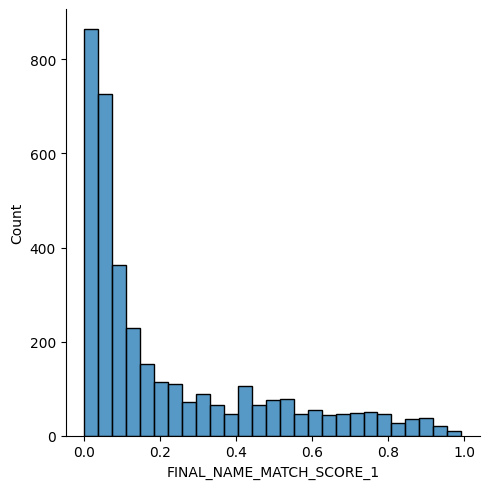

In [123]:
sns.displot(abs(y_test-df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_1"]))
plt.show()

### Miscellaneous name variations

In [124]:

# out of order word component
print(score_generation("Siddharth Gupta","Gupta Siddharth"),"Siddharth Gupta","Gupta Siddharth")

# missing word component
print(score_generation("Kamlesh Kumar Singh","Kamlesh Singh"),"Kamlesh Kumar Singh","Kamlesh Singh")
# Truncated similiar names
print(score_generation("Siddharth Gupta","Sid Gupta"),"Siddharth Gupta","Sid Gupta")

# truncated and out of order component
print(score_generation("Siddharth Gupta","Gupta Sid"),"Siddharth Gupta","Gupta Sid")
# truncated and missing word component
print(score_generation("Kamlesh Kumar Singh","Singh Kamlesh"),"Kamlesh Kumar Singh","Singh Kamlesh")

1/1 [==============================] - 0s 28ms/step
0.22901283 Siddharth Gupta Gupta Siddharth
1/1 [==============================] - 0s 26ms/step
0.46734738 Kamlesh Kumar Singh Kamlesh Singh
1/1 [==============================] - 0s 24ms/step
0.21759085 Siddharth Gupta Sid Gupta
1/1 [==============================] - 0s 36ms/step
0.061822504 Siddharth Gupta Gupta Sid
1/1 [==============================] - 0s 30ms/step
0.0716587 Kamlesh Kumar Singh Singh Kamlesh


## Model after tuning from Random Search

In [125]:
import tensorflow as tf
model_path_rs=os.path.join(folder_path,"Siamese_RS_best_model.hdf5")
model_object=tf.keras.models.load_model(model_path_rs,compile=False)

### TH alerts

In [126]:
# TH name pairs
# check for name variations
#exact names

print(score_generation("Siddharth Gupta","Siddharth Gupta"),"Siddharth Gupta","Siddharth Gupta")
# spaces and hypens
print(score_generation("Siddharth Gupta","Siddharth-Gupta"),"Siddharth Gupta","Siddharth-Gupta")
print(score_generation("Siddharth Gupta","SiddharthGupta"),"Siddharth Gupta","SiddharthGupta")

print("\n\n")
print("BIN absent")
# BIN absent
print(score_generation("MOHD KAMIL BIN SHAFIE","MOHD KAMIL SHAFIE"),"MOHD KAMIL BIN SHAFIE"," ","MOHD KAMIL SHAFIE")
print(score_generation("FARID BIN ROSNI","FARID ROSNI"),"FARID BIN ROSNI"," ","FARID ROSNI")
print(score_generation("AZMAN BIN MD ISA","AZMAN MD ISA"),"AZMAN BIN MD ISA"," ","AZMAN MD ISA")

print("\n\n")
print("Out of Order")
# out of order
print(score_generation("OOI SANG KUANG","SANG KUANG OOI"),"OOI SANG KUANG"," ","SANG KUANG OOI")
print(score_generation("LAU YU SIEW","YU SIEW LAU"),"LAU YU SIEW"," ","YU SIEW LAU")
print(score_generation("SAHRAEI MEHRNOOSH","MEHRNOOSH SAHRAEI"),"YU SIEW LAU"," ","MEHRNOOSH SAHRAEI")


print("\n\n")
print("Phenome component change ")
# phenome component change
print(score_generation("SARINA  MOHD ALI","ZARINA MOHD ALI"),"SARINA  MOHD ALI"," ","ZARINA MOHD ALI")
print(score_generation("AHMAT BIN ISMAIL","AHMAD BIN ISMAIL"),"AHMAT BIN ISMAIL"," ","AHMAD BIN ISMAIL")
print(score_generation("FENGA SHUANGXI","FENG SHUANGXI"),"FENGA SHUANGXI"," ","FENG SHUANGXI")

# out of order and phenome component change
print("\n\n")
print("out of order and phenome component change")
print(score_generation("CHENG YEW CHUAN","YEW CHUAN CHONG"),"CHENG YEW CHUAN"," ","YEW CHUAN CHONG")
print(score_generation("LIUA HONGLIN","HONGLIN LIU"),"LIUA HONGLIN"," ","HONGLIN LIU")
print(score_generation("LIM WEI JIE","WEI JIET LIM"),"LIM WEI JIE"," ","WEI JIET LIM")



1/1 [==============================] - 0s 289ms/step
0.8343857 Siddharth Gupta Siddharth Gupta
1/1 [==============================] - 0s 24ms/step
0.8344334 Siddharth Gupta Siddharth-Gupta
1/1 [==============================] - 0s 24ms/step
0.0004002742 Siddharth Gupta SiddharthGupta



BIN absent
1/1 [==============================] - 0s 24ms/step
0.0047641676 MOHD KAMIL BIN SHAFIE   MOHD KAMIL SHAFIE
1/1 [==============================] - 0s 22ms/step
0.08311921 FARID BIN ROSNI   FARID ROSNI
1/1 [==============================] - 0s 23ms/step
0.0022763428 AZMAN BIN MD ISA   AZMAN MD ISA



Out of Order
1/1 [==============================] - 0s 24ms/step
0.0002723908 OOI SANG KUANG   SANG KUANG OOI
1/1 [==============================] - 0s 24ms/step
0.003833589 LAU YU SIEW   YU SIEW LAU
1/1 [==============================] - 0s 24ms/step
5.8832404e-05 YU SIEW LAU   MEHRNOOSH SAHRAEI



Phenome component change 
1/1 [==============================] - 0s 44ms/step
0.0011039212 SARINA  M

### FH alerts

In [127]:
# FH alerts

# BIN absent
print("BIN absent")
print(score_generation("WANG BIN","WANG"), "WANG BIN"," ","WANG")

print("\n\n")
# BIN absent and phenome component change
print("BIN absent and phenome component")
print(score_generation("ROSDI BIN OMAR"," ROSLI OMAR"),"ROSDI BIN OMAR"," "," ROSLI OMAR")
print(score_generation("AZIZAM BIN MOHAMAD", "AZIZAN MOHAMAD"),"AZIZAM BIN MOHAMAD"," ", "AZIZAN MOHAMAD")
print(score_generation("HUSSIN BIN SYED ALI","HASSAN SYED ALI"),"HUSSIN BIN SYED ALI"," ","HASSAN SYED ALI")
print("\n\n")
# BIN & out of order
print("BIN & out of order")
print(score_generation("ABDUL RAHMAN BIN IBRAHIM", "IBRAHIM  ABDUL RAHMAN"),"ABDUL RAHMAN BIN IBRAHIM"," ","IBRAHIM  ABDUL RAHMAN")

# out of order
print("out of order")
print(score_generation("YANG YE","YE YANG"),"YANG YE"," ","YE YANG")
print(score_generation("LIU XIAOHUA","XIAOHUI LIU"),"LIU XIAOHUA"," ","XIAOHUI LIU")
print("\n\n")


# out of order & phenome component change
print(" out of order & phenome component change")
print(score_generation("ZHANGA YONG","SONG ZHANG"),"ZHANGA YONG"," ","SONG ZHANG")
print(score_generation("ZHANG MING", "YING ZHANG"),"ZHANG MING"," ","YING ZHANG")
print(score_generation("CHONG LEONG CHEE","CHONG CHEE KEONG"),"CHONG LEONG CHEE","CHONG CHEE KEONG")
print("\n\n")



#  phenome component change
print("phenome component change")
print(score_generation("MUHD NAVEED","MUHD JAVEED"),"MUHD NAVEED"," ","MUHD JAVEED")
print(score_generation("ABDUL HALIM","ABDUL ALIM"),"ABDUL HALIM"," ","ABDUL ALIM")
print(score_generation("ADILAH AHMAD","ADIBAH AHMAD"),"ADILAH AHMAD"," ","ADIBAH AHMAD")














BIN absent
1/1 [==============================] - 0s 25ms/step
0.5102029 WANG BIN   WANG



BIN absent and phenome component
1/1 [==============================] - 0s 24ms/step
0.009256952 ROSDI BIN OMAR    ROSLI OMAR
1/1 [==============================] - 0s 23ms/step
0.01622079 AZIZAM BIN MOHAMAD   AZIZAN MOHAMAD
1/1 [==============================] - 0s 22ms/step
0.030300705 HUSSIN BIN SYED ALI   HASSAN SYED ALI



BIN & out of order
1/1 [==============================] - 0s 24ms/step
0.00072553754 ABDUL RAHMAN BIN IBRAHIM   IBRAHIM  ABDUL RAHMAN
out of order
1/1 [==============================] - 0s 25ms/step
0.00048652897 YANG YE   YE YANG
1/1 [==============================] - 0s 23ms/step
5.0187642e-05 LIU XIAOHUA   XIAOHUI LIU



 out of order & phenome component change
1/1 [==============================] - 0s 23ms/step
0.00086134777 ZHANGA YONG   SONG ZHANG
1/1 [==============================] - 0s 25ms/step
0.051001392 ZHANG MING   YING ZHANG
1/1 [===========================

In [128]:
%%time
df_comm_val_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)
df_comm_val_to_match["ALIAS_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_ALIAS_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)

df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_2"]=df_comm_val_to_match[["ORGINAL_NAME_MATCH_SCORE","ALIAS_MATCH_SCORE"]].apply(lambda x: max(x[0],x[1]),axis=1)


y_pred=df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_2"].values
y_pred= np.array([1 if i>=0.5 else 0 for i in y_pred])

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

1/1 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2966
           1       0.57      0.92      0.71       659

    accuracy                           0.86      3625
   macro avg       0.78      0.88      0.81      3625
weighted avg       0.91      0.86      0.87      3625

CPU times: user 12min 44s, sys: 1min 37s, total: 14min 22s
Wall time: 12min 10s


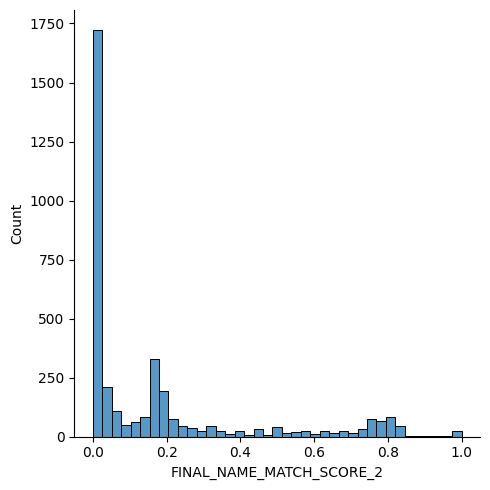

In [132]:
sns.displot(abs(y_test-df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_2"]))
plt.show()

## Model after tuning from Randomized  search and trained using best hyperparameters

In [133]:
import tensorflow as tf
model_path_rs=os.path.join(folder_path,"mixed_val_loss_trained_rs.hdf5")
model_object=tf.keras.models.load_model(model_path_rs,compile=False)

### TH alerts

In [134]:
# TH name pairs
# check for name variations
#exact names

print(score_generation("Siddharth Gupta","Siddharth Gupta"),"Siddharth Gupta","Siddharth Gupta")
# spaces and hypens
print(score_generation("Siddharth Gupta","Siddharth-Gupta"),"Siddharth Gupta","Siddharth-Gupta")
print(score_generation("Siddharth Gupta","SiddharthGupta"),"Siddharth Gupta","SiddharthGupta")

print("\n\n")
print("BIN absent")
# BIN absent
print(score_generation("MOHD KAMIL BIN SHAFIE","MOHD KAMIL SHAFIE"),"MOHD KAMIL BIN SHAFIE"," ","MOHD KAMIL SHAFIE")
print(score_generation("FARID BIN ROSNI","FARID ROSNI"),"FARID BIN ROSNI"," ","FARID ROSNI")
print(score_generation("AZMAN BIN MD ISA","AZMAN MD ISA"),"AZMAN BIN MD ISA"," ","AZMAN MD ISA")

print("\n\n")
print("Out of Order")
# out of order
print(score_generation("OOI SANG KUANG","SANG KUANG OOI"),"OOI SANG KUANG"," ","SANG KUANG OOI")
print(score_generation("LAU YU SIEW","YU SIEW LAU"),"LAU YU SIEW"," ","YU SIEW LAU")
print(score_generation("SAHRAEI MEHRNOOSH","MEHRNOOSH SAHRAEI"),"YU SIEW LAU"," ","MEHRNOOSH SAHRAEI")


print("\n\n")
print("Phenome component change ")
# phenome component change
print(score_generation("SARINA  MOHD ALI","ZARINA MOHD ALI"),"SARINA  MOHD ALI"," ","ZARINA MOHD ALI")
print(score_generation("AHMAT BIN ISMAIL","AHMAD BIN ISMAIL"),"AHMAT BIN ISMAIL"," ","AHMAD BIN ISMAIL")
print(score_generation("FENGA SHUANGXI","FENG SHUANGXI"),"FENGA SHUANGXI"," ","FENG SHUANGXI")

# out of order and phenome component change
print("\n\n")
print("out of order and phenome component change")
print(score_generation("CHENG YEW CHUAN","YEW CHUAN CHONG"),"CHENG YEW CHUAN"," ","YEW CHUAN CHONG")
print(score_generation("LIUA HONGLIN","HONGLIN LIU"),"LIUA HONGLIN"," ","HONGLIN LIU")
print(score_generation("LIM WEI JIE","WEI JIET LIM"),"LIM WEI JIE"," ","WEI JIET LIM")



1/1 [==============================] - 0s 328ms/step
0.8799463 Siddharth Gupta Siddharth Gupta
1/1 [==============================] - 0s 27ms/step
0.87836623 Siddharth Gupta Siddharth-Gupta
1/1 [==============================] - 0s 29ms/step
2.7326182e-08 Siddharth Gupta SiddharthGupta



BIN absent
1/1 [==============================] - 0s 34ms/step
1.699845e-05 MOHD KAMIL BIN SHAFIE   MOHD KAMIL SHAFIE
1/1 [==============================] - 0s 35ms/step
0.003930444 FARID BIN ROSNI   FARID ROSNI
1/1 [==============================] - 0s 26ms/step
7.788676e-07 AZMAN BIN MD ISA   AZMAN MD ISA



Out of Order
1/1 [==============================] - 0s 25ms/step
7.348179e-13 OOI SANG KUANG   SANG KUANG OOI
1/1 [==============================] - 0s 24ms/step
3.5137198e-16 LAU YU SIEW   YU SIEW LAU
1/1 [==============================] - 0s 31ms/step
1.0012546e-10 YU SIEW LAU   MEHRNOOSH SAHRAEI



Phenome component change 
1/1 [==============================] - 0s 34ms/step
5.6676643e-12 SAR

### FH alerts

In [135]:
# FH alerts

# BIN absent
print("BIN absent")
print(score_generation("WANG BIN","WANG"), "WANG BIN"," ","WANG")

print("\n\n")
# BIN absent and phenome component change
print("BIN absent and phenome component")
print(score_generation("ROSDI BIN OMAR"," ROSLI OMAR"),"ROSDI BIN OMAR"," "," ROSLI OMAR")
print(score_generation("AZIZAM BIN MOHAMAD", "AZIZAN MOHAMAD"),"AZIZAM BIN MOHAMAD"," ", "AZIZAN MOHAMAD")
print(score_generation("HUSSIN BIN SYED ALI","HASSAN SYED ALI"),"HUSSIN BIN SYED ALI"," ","HASSAN SYED ALI")
print("\n\n")
# BIN & out of order
print("BIN & out of order")
print(score_generation("ABDUL RAHMAN BIN IBRAHIM", "IBRAHIM  ABDUL RAHMAN"),"ABDUL RAHMAN BIN IBRAHIM"," ","IBRAHIM  ABDUL RAHMAN")

# out of order
print(score_generation("YANG YE","YE YANG"),"YANG YE"," ","YE YANG")
print(score_generation("LIU XIAOHUA","XIAOHUI LIU"),"LIU XIAOHUA"," ","XIAOHUI LIU")
print("\n\n")


# out of order & phenome component change
print(" out of order & phenome component change")
print(score_generation("ZHANGA YONG","SONG ZHANG"),"ZHANGA YONG"," ","SONG ZHANG")
print(score_generation("ZHANG MING", "YING ZHANG"),"ZHANG MING"," ","YING ZHANG")
print(score_generation("CHONG LEONG CHEE","CHONG CHEE KEONG"),"CHONG LEONG CHEE","CHONG CHEE KEONG")
print("\n\n")



#  phenome component change
print("phenome component change")
print(score_generation("MUHD NAVEED","MUHD JAVEED"),"MUHD NAVEED"," ","MUHD JAVEED")
print(score_generation("ABDUL HALIM","ABDUL ALIM"),"ABDUL HALIM"," ","ABDUL ALIM")
print(score_generation("ADILAH AHMAD","ADIBAH AHMAD"),"ADILAH AHMAD","ADIBAH AHMAD")














BIN absent
1/1 [==============================] - 0s 25ms/step
0.0778648 WANG BIN   WANG



BIN absent and phenome component
1/1 [==============================] - 0s 25ms/step
2.0545135e-06 ROSDI BIN OMAR    ROSLI OMAR
1/1 [==============================] - 0s 24ms/step
0.002032413 AZIZAM BIN MOHAMAD   AZIZAN MOHAMAD
1/1 [==============================] - 0s 25ms/step
1.8310045e-10 HUSSIN BIN SYED ALI   HASSAN SYED ALI



BIN & out of order
1/1 [==============================] - 0s 25ms/step
4.5754924e-14 ABDUL RAHMAN BIN IBRAHIM   IBRAHIM  ABDUL RAHMAN
1/1 [==============================] - 0s 28ms/step
5.633575e-08 YANG YE   YE YANG
1/1 [==============================] - 0s 25ms/step
1.03926e-12 LIU XIAOHUA   XIAOHUI LIU



 out of order & phenome component change
1/1 [==============================] - 0s 25ms/step
2.4277997e-12 ZHANGA YONG   SONG ZHANG
1/1 [==============================] - 0s 25ms/step
4.3717282e-08 ZHANG MING   YING ZHANG
1/1 [==============================] - 0s

In [136]:
%%time
df_comm_val_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)
df_comm_val_to_match["ALIAS_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_ALIAS_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)

df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_3"]=df_comm_val_to_match[["ORGINAL_NAME_MATCH_SCORE","ALIAS_MATCH_SCORE"]].apply(lambda x: max(x[0],x[1]),axis=1)


y_pred=df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_3"].values
y_pred= np.array([1 if i>=0.5 else 0 for i in y_pred])

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

1/1 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2966
           1       0.68      0.91      0.78       659

    accuracy                           0.91      3625
   macro avg       0.83      0.91      0.86      3625
weighted avg       0.92      0.91      0.91      3625

CPU times: user 12min 48s, sys: 1min 34s, total: 14min 23s
Wall time: 12min 15s


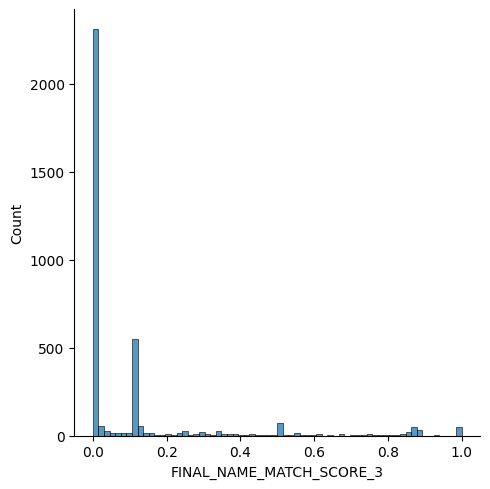

In [137]:
sns.displot(abs(y_test-df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_3"]))
plt.show()

## Model after tuning from Baeysian optimization 

In [138]:
folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
model_path=os.path.join(folder_path,"Siamese_BO.hdf5")
model_object=tensorflow.keras.models.load_model(model_path,compile=False)

### TH alerts

In [139]:
# TH name pairs
# check for name variations
#exact names

print(score_generation("Siddharth Gupta","Siddharth Gupta"),"Siddharth Gupta","Siddharth Gupta")
# spaces and hypens
print(score_generation("Siddharth Gupta","Siddharth-Gupta"),"Siddharth Gupta","Siddharth-Gupta")
print(score_generation("Siddharth Gupta","SiddharthGupta"),"Siddharth Gupta","SiddharthGupta")

print("\n\n")
print("BIN absent")
# BIN absent
print(score_generation("MOHD KAMIL BIN SHAFIE","MOHD KAMIL SHAFIE"),"MOHD KAMIL BIN SHAFIE"," ","MOHD KAMIL SHAFIE")
print(score_generation("FARID BIN ROSNI","FARID ROSNI"),"FARID BIN ROSNI"," ","FARID ROSNI")
print(score_generation("AZMAN BIN MD ISA","AZMAN MD ISA"),"AZMAN BIN MD ISA"," ","AZMAN MD ISA")

print("\n\n")
print("Out of Order")
# out of order
print(score_generation("OOI SANG KUANG","SANG KUANG OOI"),"OOI SANG KUANG"," ","SANG KUANG OOI")
print(score_generation("LAU YU SIEW","YU SIEW LAU"),"LAU YU SIEW"," ","YU SIEW LAU")
print(score_generation("SAHRAEI MEHRNOOSH","MEHRNOOSH SAHRAEI"),"YU SIEW LAU"," ","MEHRNOOSH SAHRAEI")


print("\n\n")
print("Phenome component change ")
# phenome component change
print(score_generation("SARINA  MOHD ALI","ZARINA MOHD ALI"),"SARINA  MOHD ALI"," ","ZARINA MOHD ALI")
print(score_generation("AHMAT BIN ISMAIL","AHMAD BIN ISMAIL"),"AHMAT BIN ISMAIL"," ","AHMAD BIN ISMAIL")
print(score_generation("FENGA SHUANGXI","FENG SHUANGXI"),"FENGA SHUANGXI"," ","FENG SHUANGXI")

# out of order and phenome component change
print("\n\n")
print("out of order and phenome component change")
print(score_generation("CHENG YEW CHUAN","YEW CHUAN CHONG"),"CHENG YEW CHUAN"," ","YEW CHUAN CHONG")
print(score_generation("LIUA HONGLIN","HONGLIN LIU"),"LIUA HONGLIN"," ","HONGLIN LIU")
print(score_generation("LIM WEI JIE","WEI JIET LIM"),"LIM WEI JIE"," ","WEI JIET LIM")



1/1 [==============================] - 0s 370ms/step
0.49948278 Siddharth Gupta Siddharth Gupta
1/1 [==============================] - 0s 29ms/step
0.49952018 Siddharth Gupta Siddharth-Gupta
1/1 [==============================] - 0s 29ms/step
0.4994876 Siddharth Gupta SiddharthGupta



BIN absent
1/1 [==============================] - 0s 29ms/step
0.49931967 MOHD KAMIL BIN SHAFIE   MOHD KAMIL SHAFIE
1/1 [==============================] - 0s 28ms/step
0.49923098 FARID BIN ROSNI   FARID ROSNI
1/1 [==============================] - 0s 27ms/step
0.49900863 AZMAN BIN MD ISA   AZMAN MD ISA



Out of Order
1/1 [==============================] - 0s 27ms/step
0.49926975 OOI SANG KUANG   SANG KUANG OOI
1/1 [==============================] - 0s 29ms/step
0.49934584 LAU YU SIEW   YU SIEW LAU
1/1 [==============================] - 0s 29ms/step
0.49932146 YU SIEW LAU   MEHRNOOSH SAHRAEI



Phenome component change 
1/1 [==============================] - 0s 28ms/step
0.49942383 SARINA  MOHD ALI   ZAR

### FH alerts

In [140]:
# FH alerts

# BIN absent
print("BIN absent")
print(score_generation("WANG BIN","WANG"), "WANG BIN"," ","WANG")

print("\n\n")
# BIN absent and phenome component change
print("BIN absent and phenome component")
print(score_generation("ROSDI BIN OMAR"," ROSLI OMAR"),"ROSDI BIN OMAR"," "," ROSLI OMAR")
print(score_generation("AZIZAM BIN MOHAMAD", "AZIZAN MOHAMAD"),"AZIZAM BIN MOHAMAD"," ", "AZIZAN MOHAMAD")
print(score_generation("HUSSIN BIN SYED ALI","HASSAN SYED ALI"),"HUSSIN BIN SYED ALI"," ","HASSAN SYED ALI")
print("\n\n")
# BIN & out of order
print("BIN & out of order")
print(score_generation("ABDUL RAHMAN BIN IBRAHIM", "IBRAHIM  ABDUL RAHMAN"),"ABDUL RAHMAN BIN IBRAHIM"," ","IBRAHIM  ABDUL RAHMAN")

# out of order
print(score_generation("YANG YE","YE YANG"),"YANG YE"," ","YE YANG")
print(score_generation("LIU XIAOHUA","XIAOHUI LIU"),"LIU XIAOHUA"," ","XIAOHUI LIU")
print("\n\n")


# out of order & phenome component change
print(" out of order & phenome component change")
print(score_generation("ZHANGA YONG","SONG ZHANG"),"ZHANGA YONG"," ","SONG ZHANG")
print(score_generation("ZHANG MING", "YING ZHANG"),"ZHANG MING"," ","YING ZHANG")
print(score_generation("CHONG LEONG CHEE","CHONG CHEE KEONG"),"CHONG LEONG CHEE","CHONG CHEE KEONG")
print("\n\n")



#  phenome component change
print("phenome component change")
print(score_generation("MUHD NAVEED","MUHD JAVEED"),"MUHD NAVEED"," ","MUHD JAVEED")
print(score_generation("ABDUL HALIM","ABDUL ALIM"),"ABDUL HALIM"," ","ABDUL ALIM")
print(score_generation("ADILAH AHMAD","ADIBAH AHMAD"),"ADILAH AHMAD"," ","ADIBAH AHMAD")














BIN absent
1/1 [==============================] - 0s 30ms/step
0.4990033 WANG BIN   WANG



BIN absent and phenome component
1/1 [==============================] - 0s 32ms/step
0.49905166 ROSDI BIN OMAR    ROSLI OMAR
1/1 [==============================] - 0s 37ms/step
0.49916783 AZIZAM BIN MOHAMAD   AZIZAN MOHAMAD
1/1 [==============================] - 0s 30ms/step
0.49931076 HUSSIN BIN SYED ALI   HASSAN SYED ALI



BIN & out of order
1/1 [==============================] - 0s 30ms/step
0.4993987 ABDUL RAHMAN BIN IBRAHIM   IBRAHIM  ABDUL RAHMAN
1/1 [==============================] - 0s 29ms/step
0.49934316 YANG YE   YE YANG
1/1 [==============================] - 0s 28ms/step
0.49909687 LIU XIAOHUA   XIAOHUI LIU



 out of order & phenome component change
1/1 [==============================] - 0s 28ms/step
0.49904913 ZHANGA YONG   SONG ZHANG
1/1 [==============================] - 0s 28ms/step
0.49923414 ZHANG MING   YING ZHANG
1/1 [==============================] - 0s 29ms/step
0.4995807

In [141]:
%%time
df_comm_val_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)
df_comm_val_to_match["ALIAS_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_ALIAS_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)

df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_4"]=df_comm_val_to_match[["ORGINAL_NAME_MATCH_SCORE","ALIAS_MATCH_SCORE"]].apply(lambda x: max(x[0],x[1]),axis=1)


y_pred=df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_4"].values
y_pred= np.array([1 if i>=0.5 else 0 for i in y_pred])

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

1/1 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2966
           1       0.00      0.00      0.00       659

    accuracy                           0.82      3625
   macro avg       0.41      0.50      0.45      3625
weighted avg       0.67      0.82      0.74      3625

CPU times: user 12min 22s, sys: 1min 34s, total: 13min 56s
Wall time: 11min 44s


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


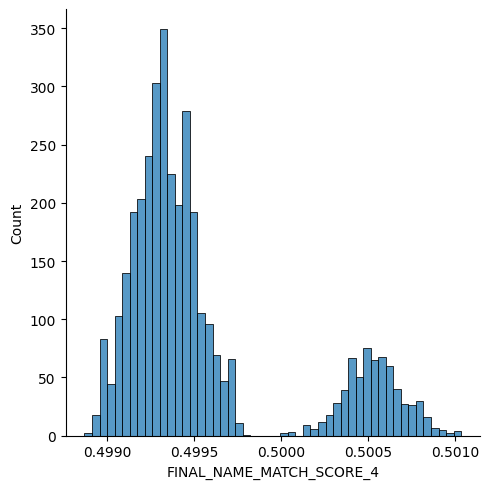

In [142]:
sns.displot(abs(y_test-df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_4"]))
plt.show()

## Model after tuning hyperparameters using Bayesian Optimization and re-training the model object

In [143]:
# loading Siamese model object
folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
model_path=os.path.join(folder_path,"mixed_val_loss_bo.hdf5")

model_object=tensorflow.keras.models.load_model(model_path,compile=False)

### TH alerts

In [144]:
# TH name pairs
# check for name variations
#exact names

print(score_generation("Siddharth Gupta","Siddharth Gupta"),"Siddharth Gupta","Siddharth Gupta")
# spaces and hypens
print(score_generation("Siddharth Gupta","Siddharth-Gupta"),"Siddharth Gupta","Siddharth-Gupta")
print(score_generation("Siddharth Gupta","SiddharthGupta"),"Siddharth Gupta","SiddharthGupta")

print("\n\n")
print("BIN absent")
# BIN absent
print(score_generation("MOHD KAMIL BIN SHAFIE","MOHD KAMIL SHAFIE"),"MOHD KAMIL BIN SHAFIE"," ","MOHD KAMIL SHAFIE")
print(score_generation("FARID BIN ROSNI","FARID ROSNI"),"FARID BIN ROSNI"," ","FARID ROSNI")
print(score_generation("AZMAN BIN MD ISA","AZMAN MD ISA"),"AZMAN BIN MD ISA"," ","AZMAN MD ISA")

print("\n\n")
print("Out of Order")
# out of order
print(score_generation("OOI SANG KUANG","SANG KUANG OOI"),"OOI SANG KUANG"," ","SANG KUANG OOI")
print(score_generation("LAU YU SIEW","YU SIEW LAU"),"LAU YU SIEW"," ","YU SIEW LAU")
print(score_generation("SAHRAEI MEHRNOOSH","MEHRNOOSH SAHRAEI"),"YU SIEW LAU"," ","MEHRNOOSH SAHRAEI")


print("\n\n")
print("Phenome component change ")
# phenome component change
print(score_generation("SARINA  MOHD ALI","ZARINA MOHD ALI"),"SARINA  MOHD ALI"," ","ZARINA MOHD ALI")
print(score_generation("AHMAT BIN ISMAIL","AHMAD BIN ISMAIL"),"AHMAT BIN ISMAIL"," ","AHMAD BIN ISMAIL")
print(score_generation("FENGA SHUANGXI","FENG SHUANGXI"),"FENGA SHUANGXI"," ","FENG SHUANGXI")

# out of order and phenome component change
print("\n\n")
print("out of order and phenome component change")
print(score_generation("CHENG YEW CHUAN","YEW CHUAN CHONG"),"CHENG YEW CHUAN"," ","YEW CHUAN CHONG")
print(score_generation("LIUA HONGLIN","HONGLIN LIU"),"LIUA HONGLIN"," ","HONGLIN LIU")
print(score_generation("LIM WEI JIE","WEI JIET LIM"),"LIM WEI JIE"," ","WEI JIET LIM")



1/1 [==============================] - 0s 366ms/step
0.84648913 Siddharth Gupta Siddharth Gupta
1/1 [==============================] - 0s 27ms/step
0.8464718 Siddharth Gupta Siddharth-Gupta
1/1 [==============================] - 0s 28ms/step
3.255841e-05 Siddharth Gupta SiddharthGupta



BIN absent
1/1 [==============================] - 0s 26ms/step
0.013950828 MOHD KAMIL BIN SHAFIE   MOHD KAMIL SHAFIE
1/1 [==============================] - 0s 26ms/step
0.11463289 FARID BIN ROSNI   FARID ROSNI
1/1 [==============================] - 0s 25ms/step
0.06781321 AZMAN BIN MD ISA   AZMAN MD ISA



Out of Order
1/1 [==============================] - 0s 25ms/step
0.00026739915 OOI SANG KUANG   SANG KUANG OOI
1/1 [==============================] - 0s 24ms/step
0.003351156 LAU YU SIEW   YU SIEW LAU
1/1 [==============================] - 0s 25ms/step
0.00019363624 YU SIEW LAU   MEHRNOOSH SAHRAEI



Phenome component change 
1/1 [==============================] - 0s 29ms/step
0.0002228583 SARINA  MO

### FH alerts

In [145]:
# FH alerts

# BIN absent
print("BIN absent")
print(score_generation("WANG BIN","WANG"), "WANG BIN"," ","WANG")

print("\n\n")
# BIN absent and phenome component change
print("BIN absent and phenome component")
print(score_generation("ROSDI BIN OMAR"," ROSLI OMAR"),"ROSDI BIN OMAR"," "," ROSLI OMAR")
print(score_generation("AZIZAM BIN MOHAMAD", "AZIZAN MOHAMAD"),"AZIZAM BIN MOHAMAD"," ", "AZIZAN MOHAMAD")
print(score_generation("HUSSIN BIN SYED ALI","HASSAN SYED ALI"),"HUSSIN BIN SYED ALI"," ","HASSAN SYED ALI")
print("\n\n")
# BIN & out of order
print("BIN & out of order")
print(score_generation("ABDUL RAHMAN BIN IBRAHIM", "IBRAHIM  ABDUL RAHMAN"),"ABDUL RAHMAN BIN IBRAHIM"," ","IBRAHIM  ABDUL RAHMAN")

# out of order
print(score_generation("YANG YE","YE YANG"),"YANG YE"," ","YE YANG")
print(score_generation("LIU XIAOHUA","XIAOHUI LIU"),"LIU XIAOHUA"," ","XIAOHUI LIU")
print("\n\n")


# out of order & phenome component change
print(" out of order & phenome component change")
print(score_generation("ZHANGA YONG","SONG ZHANG"),"ZHANGA YONG"," ","SONG ZHANG")
print(score_generation("ZHANG MING", "YING ZHANG"),"ZHANG MING"," ","YING ZHANG")
print(score_generation("CHONG LEONG CHEE","CHONG CHEE KEONG"),"CHONG LEONG CHEE","CHONG CHEE KEONG")
print("\n\n")



#  phenome component change
print("phenome component change")
print(score_generation("MUHD NAVEED","MUHD JAVEED"),"MUHD NAVEED"," ","MUHD JAVEED")
print(score_generation("ABDUL HALIM","ABDUL ALIM"),"ABDUL HALIM"," ","ABDUL ALIM")
print(score_generation("ADILAH AHMAD","ADIBAH AHMAD"),"ADILAH AHMAD"," ","ADIBAH AHMAD")














BIN absent
1/1 [==============================] - 0s 26ms/step
0.51737994 WANG BIN   WANG



BIN absent and phenome component
1/1 [==============================] - 0s 27ms/step
0.00022198012 ROSDI BIN OMAR    ROSLI OMAR
1/1 [==============================] - 0s 26ms/step
0.13853358 AZIZAM BIN MOHAMAD   AZIZAN MOHAMAD
1/1 [==============================] - 0s 27ms/step
0.008310762 HUSSIN BIN SYED ALI   HASSAN SYED ALI



BIN & out of order
1/1 [==============================] - 0s 26ms/step
3.6631747e-05 ABDUL RAHMAN BIN IBRAHIM   IBRAHIM  ABDUL RAHMAN
1/1 [==============================] - 0s 27ms/step
0.05329212 YANG YE   YE YANG
1/1 [==============================] - 0s 25ms/step
0.0004100085 LIU XIAOHUA   XIAOHUI LIU



 out of order & phenome component change
1/1 [==============================] - 0s 25ms/step
6.7756387e-06 ZHANGA YONG   SONG ZHANG
1/1 [==============================] - 0s 25ms/step
1.3201227e-06 ZHANG MING   YING ZHANG
1/1 [==============================] - 0s 25

In [146]:
%%time
df_comm_val_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)
df_comm_val_to_match["ALIAS_MATCH_SCORE"]=df_comm_val_to_match.loc[:,["ALL_ALIAS_NAMES","ALL_WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)

1/1 [==============================] - 0s 26ms/step
CPU times: user 12min 26s, sys: 1min 42s, total: 14min 8s
Wall time: 11min 45s


In [147]:
df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_5"]=df_comm_val_to_match[["ORGINAL_NAME_MATCH_SCORE","ALIAS_MATCH_SCORE"]].apply(lambda x: max(x[0],x[1]),axis=1)

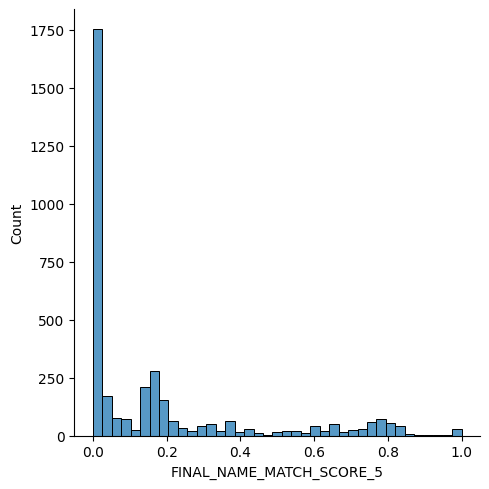

In [148]:
sns.displot(abs(y_test-df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_5"]))
plt.show()

In [149]:
y_pred=df_comm_val_to_match["FINAL_NAME_MATCH_SCORE_5"].values
y_pred= np.array([1 if i>=0.5 else 0 for i in y_pred])

In [150]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      2966
           1       0.56      0.92      0.70       659

    accuracy                           0.86      3625
   macro avg       0.77      0.88      0.80      3625
weighted avg       0.90      0.86      0.87      3625



In [151]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[2497,  469],
       [  50,  609]])